In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization, concatenate, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasRegressor
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import scipy
import os
import random
import math

seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Import needed files for spatial analysis:



*   House Listings scraped from Trulia
*   Location data for all Arizona supermarkets
*   Location data for all Arizona stores
*   Arizona population data by city





In [ ]:
trulia_df = pd.read_csv('/content/trulia_data.csv')

In [ ]:
stores_df_raw = pd.read_csv('/content/Arizona_stores_latlong.csv')
stores_df = stores_df_raw.reset_index()

In [ ]:
schools_df = pd.read_excel('/content/Schools.xlsx')

In [ ]:
pop_df = pd.read_csv('/content/us-cities-table-for-arizona.csv')

Clean data: remove missing values, create numeric versions of variables, etc

In [ ]:
trulia_df.isna().sum()

address              0
city                 0
state                0
zipcode              0
latitude             0
longitude            0
price                2
link                 0
floor_space         45
beds                37
baths              109
year_built          35
parking            485
price_per_sqft      46
HOA                936
heating           1079
cooling           1079
outdoor           1065
pool               266
laundry           1079
listing_agent      845
broker             290
date                 6
date_type            6
sold_indicator       0
dtype: int64

In [ ]:
trulia_df_notnull = trulia_df[trulia_df['price'].notna() & trulia_df['date'].notna() & trulia_df['year_built'].notna() & trulia_df['floor_space'].notna()]

In [ ]:
price_num = []
for h in trulia_df_notnull['price']:
    price_num += [float(h.replace('$','').replace(',',''))]
trulia_df_notnull['price_num'] = price_num
date_str = []
year = []
for i in trulia_df_notnull['date']:
    year += [int(i.split('-')[0])]
    if str(i).find('T') == -1:
        date_str += [str(i) + 'T00:00:00+00:00']
    else:
        date_str += [str(i)]
trulia_df_notnull['date_str'] = date_str
trulia_df_notnull['year'] = year
trulia_df_notnull['date_format'] = pd.to_datetime(trulia_df_notnull['date_str'])
trulia_df_notnull['house_age'] = np.where(trulia_df_notnull['year_built'].notna(),trulia_df_notnull['year']-trulia_df_notnull['year_built'],np.nan)
floor_space_str = []
for j in trulia_df_notnull['floor_space']:
    floor_space_str += [str(j)]
trulia_df_notnull['floor_space_str'] = floor_space_str
floor_space_num = []
for k in trulia_df_notnull['floor_space_str']:
    if k == 'nan':
        floor_space_num += [np.nan]
    else:
        floor_space_num += [float(k.replace(',','').replace('sqft','').strip())]
trulia_df_notnull['floor_space_num'] = floor_space_num
beds_num = []
for l in trulia_df_notnull['beds']:
    if str(l) == 'nan':
        beds_num += [np.nan]
    elif str(l) == 'Studio':
        beds_num += [0]
    else:
        beds_num += [int(l[:1])]
trulia_df_notnull['beds_num'] = beds_num
baths_num = []
for m in trulia_df_notnull['baths']:
    if str(m) == 'nan':
        baths_num += [np.nan]
    elif str(m) == 'Studio':
        baths_num += [0]
    else:
        baths_num += [int(m[:1])]
trulia_df_notnull['baths_num'] = baths_num
trulia_df_notnull['garage_ind'] = np.where(trulia_df_notnull['parking']=='Garage',1,0)
price_per_sqft_num = []
for n in trulia_df_notnull['price_per_sqft']:
    if str(n) == 'nan':
        price_per_sqft_num += [np.nan]
    else:
        price_per_sqft_num += [float(str(n).replace(',','').replace('$','').replace('/sqft','').strip())]
trulia_df_notnull['price_per_sqft_num'] = price_per_sqft_num

<ipython-input-9-825ed74b0857>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trulia_df_notnull['price_num'] = price_num
<ipython-input-9-825ed74b0857>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trulia_df_notnull['date_str'] = date_str
<ipython-input-9-825ed74b0857>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Merge all needed datasets together into one spatial dataset and compute distances from houses to a store/school

In [ ]:
trulia_merge_pop = trulia_df_notnull.merge(pop_df, how='outer', left_on=['city'], right_on=['name'])
trulia_merge_pop = trulia_merge_pop[trulia_merge_pop['price'].notna() & trulia_merge_pop['pop2024'].notna()].drop(columns=['pop2020','growth','name','aland_sqmi','intptlat','intptlong','slug','usps','lsad','lng','lat','type','rank'])
trulia_merge_pop = trulia_merge_pop.reset_index()

In [ ]:
#Haversine function to compute distance
def haversine(latA,longA,latB,longB):
    latA_rad = math.radians(latA)
    longA_rad = math.radians(longB)
    latB_rad = math.radians(latB)
    longB_rad = math.radians(longB)
    step1 = (math.sin((latA_rad - latB_rad)/2)**2) + math.cos(latA_rad)*math.cos(latB_rad)*(math.sin((longA_rad - longB_rad)/2)**2)
    step2 = 2*math.atan2(math.sqrt(step1), math.sqrt(1 - step1))
    step3 = 6371*step2 #multiply by Earth's circumference in km
    return step3

In [ ]:
minSchoolDistFinal = pd.DataFrame(columns=['homeAddress','min_school_dist','DistrictEntityID','SchoolEntityID','DistrictName','SchoolName','DistrictType','SchoolType','SchoolAddress','SchoolCity','SchoolState','SchoolZip','SchoolLatitude','SchoolLongitude'])
for row in range(len(trulia_merge_pop)):
    #print(trulia_merge_pop.loc[row]['latitude'])
    #print(trulia_merge_pop.loc[row]['longitude'])
    school_dist = {}
    for school in range(len(schools_df)):
        #print(schools_df.loc[school]['lon'])
        dist = haversine(trulia_merge_pop.loc[row]['latitude'],trulia_merge_pop.loc[row]['longitude'],schools_df.loc[school]['lat'],schools_df.loc[school]['lon'])
        school_dist[dist] = {'DistrictEntityID':schools_df.loc[school]['DistrictEntityID'],'SchoolEntityID':schools_df.loc[school]['SchoolEntityID'],'DistrictName':schools_df.loc[school]['DistrictName'],'SchoolName':schools_df.loc[school]['SchoolName'],'DistrictType':schools_df.loc[school]['DistrictType'],'SchoolType':schools_df.loc[school]['SchoolType'],'SchoolAddress':schools_df.loc[school]['PAddress'],'SchoolCity':schools_df.loc[school]['PCity'],'SchoolState':schools_df.loc[school]['PState'],'SchoolZip':schools_df.loc[school]['ZIP5'],'SchoolLatitude':schools_df.loc[school]['lat'],'SchoolLongitude':schools_df.loc[school]['lon']}
    minSchoolDist = min(school_dist.keys())
    #print(type(school_dist[minSchoolDist]))
    minSchoolDist_df = pd.DataFrame(school_dist[minSchoolDist],index=[row])
    minSchoolDist_df['homeAddress'] = trulia_merge_pop.loc[row]['address']
    minSchoolDist_df['min_school_dist'] = minSchoolDist
    minSchoolDistFinal = pd.concat([minSchoolDistFinal,minSchoolDist_df])

In [ ]:
minStoreDistFinal = pd.DataFrame(columns=['homeAddress','min_store_dist','store_name','store_address','store_city','store_state','store_zipcode','store_phone_number','StoreLatitude','StoreLongitude'])
for row in range(len(trulia_merge_pop)):
    store_dist = {}
    for store in range(len(stores_df)):
        dist = haversine(trulia_merge_pop.loc[row]['latitude'],trulia_merge_pop.loc[row]['longitude'],stores_df.loc[store]['lat'],stores_df.loc[store]['long'])
        store_dist[dist] = {'store_name':stores_df.loc[store]['name'],'store_address':stores_df.loc[store]['address'],'store_city':stores_df.loc[store]['city'],'store_state':stores_df.loc[store]['state'],'store_zipcode':stores_df.loc[store]['zipcode'],'store_phone_number':stores_df.loc[store]['phone_number'],'StoreLatitude':stores_df.loc[store]['lat'],'StoreLongitude':stores_df.loc[store]['long']}
    minStoreDist = min(store_dist.keys())
    minStoreDist_df = pd.DataFrame(store_dist[minStoreDist],index=[0])
    minStoreDist_df['homeAddress'] = trulia_merge_pop.loc[row]['address']
    minStoreDist_df['min_store_dist'] = minStoreDist
    minStoreDistFinal = pd.concat([minStoreDistFinal,minStoreDist_df])

In [ ]:
data_merge_school_raw = trulia_merge_pop.merge(minSchoolDistFinal, how='outer', left_on=['address'], right_on=['homeAddress'])
data_merge_school = data_merge_school_raw[data_merge_school_raw['price'].notna()].drop_duplicates()
data_merge_store_raw = data_merge_school.merge(minStoreDistFinal, how='outer', left_on=['address'], right_on=['homeAddress'])
data_merge_store = data_merge_store_raw[data_merge_store_raw['price'].notna()].drop_duplicates()

Save data up to this point to csv file

In [ ]:
data_merge_store.to_csv('data_merge_store.csv')

In [ ]:
data_merge_store = pd.read_csv('/content/data_merge_store.csv')

Keep only needed columns, filter out outliers, and examine variable distributions with boxplots.

In [ ]:
final_df = data_merge_store[['price_num','city','year','house_age','floor_space_num','beds_num','baths_num','garage_ind','price_per_sqft_num','pop2024','density','min_school_dist','min_store_dist']]

In [ ]:
final_df_rem_out = final_df[(final_df['price_num'] < 10000000) & (final_df['price_per_sqft_num'] < 1000) & (final_df['floor_space_num'] < 10000)]
final_df_rem_out = final_df_rem_out.reset_index()

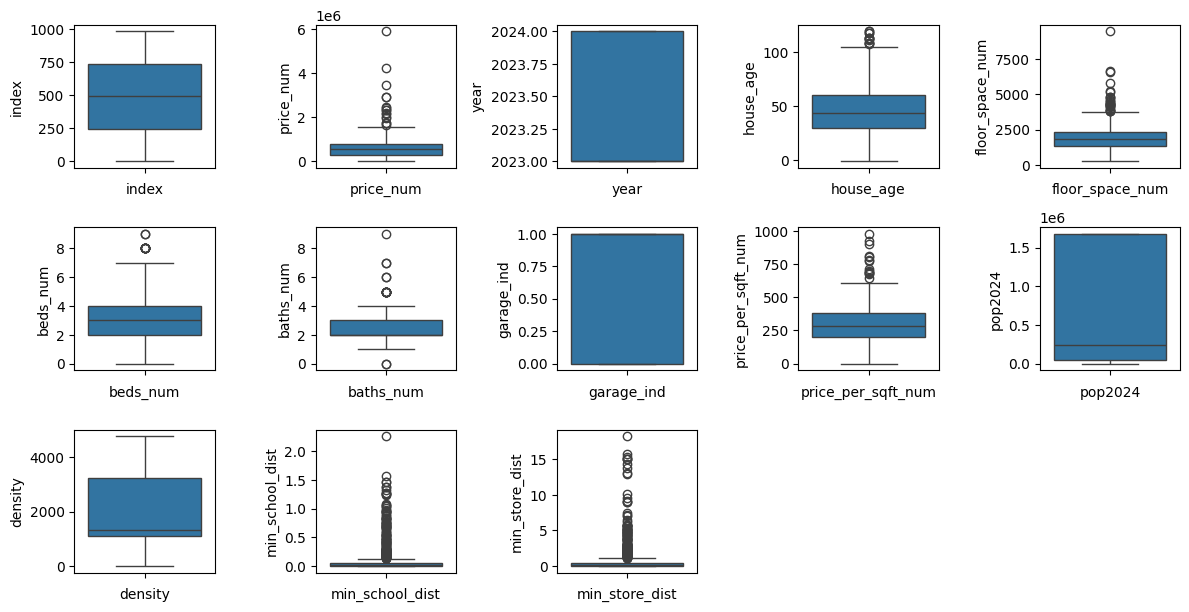

In [ ]:
plt.figure(figsize = (12,12))

for i,j in enumerate(final_df_rem_out.select_dtypes(include = "number").columns):

    plt.subplot(6,5,i+1)

    sns.boxplot(final_df_rem_out[j])
    plt.xlabel("{}".format(j))

    plt.tight_layout()

plt.subplots_adjust()
plt.show()

In [ ]:
final_df_small = final_df_rem_out[['price_num','city','year','house_age','garage_ind','price_per_sqft_num','pop2024','density','floor_space_num','min_school_dist','min_store_dist','beds_num','baths_num']]

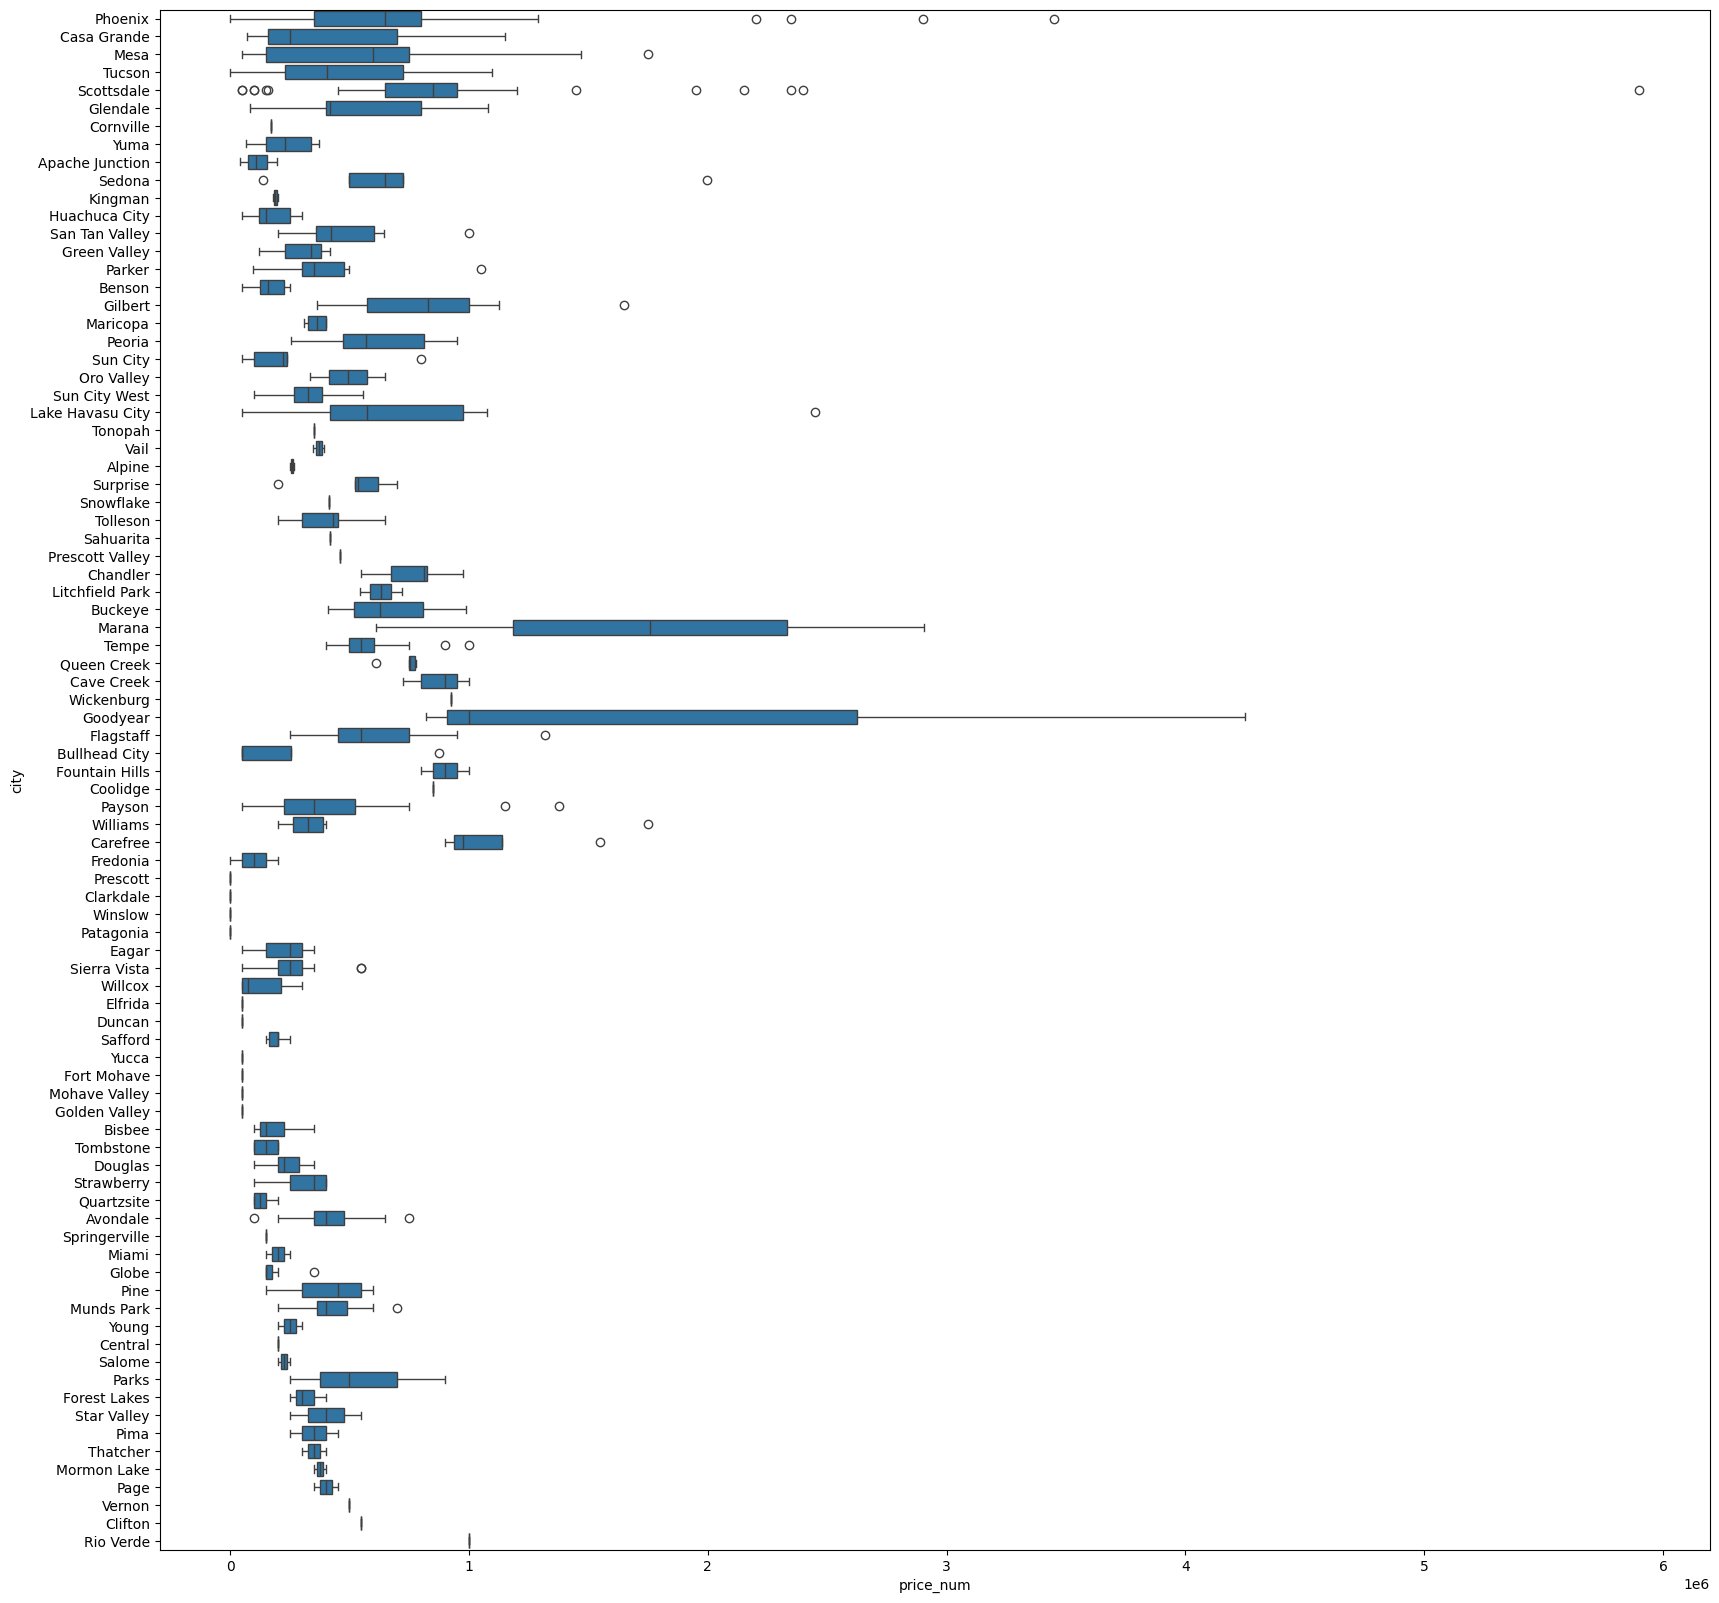

In [ ]:
plt.figure(figsize = (20,20))
sns.boxplot(data=final_df_small,x='price_num',y='city')
plt.show()

Correlation Analysis

In [ ]:
corr_all_matrix = final_df_small.select_dtypes(include = "number").corr()

corr_all_df = corr_all_matrix.stack().reset_index()
corr_all_df.columns = ['v1', 'v2', 'correlation']

corr_all_df_sort = corr_all_df.loc[corr_all_df.correlation.abs().sort_values(ascending= False).index]
corr_all_df_sort.loc[(corr_all_df_sort.v1 == 'price_num')]

,v1,v2,correlation
0,price_num,price_num,1.000000
4,price_num,price_per_sqft_num,0.685061
7,price_num,floor_space_num,0.672881
11,price_num,baths_num,0.579883
3,price_num,garage_ind,0.397193
10,price_num,beds_num,0.384743
2,price_num,house_age,-0.241299
9,price_num,min_store_dist,-0.138965
1,price_num,year,0.125751
8,price_num,min_school_dist,-0.112845


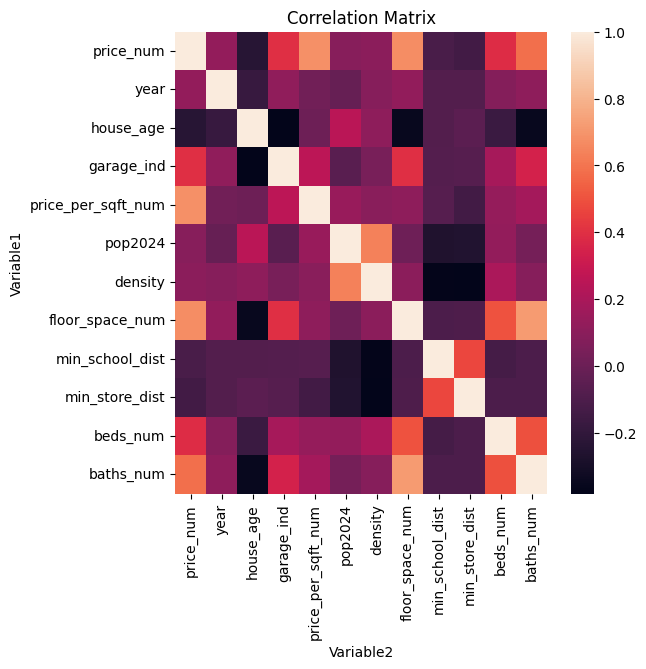

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(corr_all_matrix)
plt.title('Correlation Matrix')
plt.ylabel('Variable1')
plt.xlabel('Variable2')
plt.show()

Data Imputation

In [ ]:
final_df_small.isna().sum()

price_num              0
city                   0
year                   0
house_age              0
garage_ind             0
price_per_sqft_num     0
pop2024                0
density                0
floor_space_num        0
min_school_dist        0
min_store_dist         0
beds_num               6
baths_num             57
dtype: int64

In [ ]:
minimum = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['beds_num']).min()
median = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['beds_num']).median()
maximum = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['beds_num']).max()
mean = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['beds_num']).mean()
pd.concat([minimum,median,maximum,mean],axis=1)

,floor_space_num,floor_space_num,floor_space_num,floor_space_num
beds_num,,,,
0.0,324,1480.0,9461,1576.254098
1.0,400,676.0,1232,716.074074
2.0,264,1192.0,3598,1299.000000
3.0,672,1739.0,4184,1838.787466
4.0,1344,2266.0,6648,2420.555085
5.0,1491,2802.0,5810,3000.489796
6.0,1938,2787.0,6566,3264.937500
7.0,2450,2450.0,2450,2450.000000
8.0,1000,3200.0,3696,2952.400000


In [ ]:
minimum = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['baths_num']).min()
median = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['baths_num']).median()
maximum = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['baths_num']).max()
mean = final_df_rem_out['floor_space_num'].groupby(final_df_rem_out['baths_num']).mean()
pd.concat([minimum,median,maximum,mean],axis=1)

,floor_space_num,floor_space_num,floor_space_num,floor_space_num
baths_num,,,,
0.0,480,502.0,524,502.000000
1.0,264,897.0,3696,1078.301587
2.0,530,1690.5,3134,1718.478903
3.0,1278,2376.5,6648,2438.396552
4.0,1650,3199.5,5146,3125.828571
5.0,2100,3966.0,4804,3856.100000
6.0,5208,5509.0,5810,5509.000000
7.0,1000,3783.0,6566,3783.000000
9.0,3468,3468.0,3468,3468.000000


In [ ]:
bed_update = []
for rec in range(len(final_df_rem_out)):
    if np.isnan(final_df_rem_out.loc[rec]['beds_num']) == False:
        bed_update += [final_df_rem_out.loc[rec]['beds_num']]
    elif final_df_rem_out.loc[rec]['floor_space_num'] < 900:
        bed_update += [1]
    elif 900 <= final_df_rem_out.loc[rec]['floor_space_num'] < 1500:
        bed_update += [2]
    elif 1500 <= final_df_rem_out.loc[rec]['floor_space_num'] < 2000:
        bed_update += [3]
    elif 2000 <= final_df_rem_out.loc[rec]['floor_space_num'] < 2550:
        bed_update += [4]
    else:
        bed_update += [5]
bath_update = []
for rec in range(len(final_df_rem_out)):
    if np.isnan(final_df_rem_out.loc[rec]['baths_num']) == False:
        bath_update += [final_df_rem_out.loc[rec]['baths_num']]
    elif final_df_rem_out.loc[rec]['floor_space_num'] < 1300:
        bath_update += [1]
    elif 1300 <= final_df_rem_out.loc[rec]['floor_space_num'] < 2050:
        bath_update += [2]
    elif 2050 <= final_df_rem_out.loc[rec]['floor_space_num'] < 2800:
        bath_update += [3]
    elif 2800 <= final_df_rem_out.loc[rec]['floor_space_num'] < 3550:
        bath_update += [4]
    elif 3550 <= final_df_rem_out.loc[rec]['floor_space_num'] < 5000:
        bath_update += [5]
    else:
        bath_update += [6]

final_df_impute = final_df_rem_out.drop(columns=['beds_num','baths_num'])
final_df_impute['beds_num'] = bed_update
final_df_impute['baths_num'] = bath_update

Save final cleaned spatial data file

In [ ]:
final_df_impute[['price_num','city','year','house_age','garage_ind','price_per_sqft_num','pop2024','density','floor_space_num','min_school_dist','min_store_dist','beds_num','baths_num']].to_csv('final_housing_data.csv')

In [ ]:
spatial_data_raw = pd.read_csv('/content/final_housing_data.csv')
spatial_data = spatial_data_raw[['price_num','city','year','house_age','garage_ind','price_per_sqft_num','pop2024','density','floor_space_num','min_school_dist','min_store_dist','beds_num','baths_num']]
display(spatial_data)

,price_num,city,year,house_age,garage_ind,price_per_sqft_num,pop2024,density,floor_space_num,min_school_dist,min_store_dist,beds_num,baths_num
0,185000,Phoenix,2024,51,1,168,1676481,3234,1100,0.012764,0.002969,2.0,2.0
1,169900,Phoenix,2024,61,1,242,1676481,3234,702,0.018489,0.021172,1.0,1.0
2,99500,Phoenix,2024,53,0,66,1676481,3234,1512,0.027269,0.164535,2.0,2.0
3,175000,Phoenix,2024,17,0,311,1676481,3234,563,0.023884,0.107637,1.0,1.0
4,165000,Phoenix,2024,54,0,197,1676481,3234,836,0.005792,0.331672,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,350000,Page,2023,46,1,247,7297,191,1419,0.044256,0.105691,3.0,2.0
972,450000,Page,2024,63,0,209,7297,191,2158,0.042699,0.020182,4.0,3.0
973,500000,Vernon,2023,31,1,175,317,560,2850,0.114642,2.684913,2.0,3.0
974,550000,Clifton,2023,33,0,277,3627,247,1987,0.005508,0.820396,0.0,2.0


,price_num,city,year,house_age,garage_ind,price_per_sqft_num,pop2024,density,floor_space_num,min_school_dist,min_store_dist,beds_num,baths_num
0,185000,Phoenix,2024,51,1,168,1676481,3234,1100,0.012764,0.002969,2.0,2.0
1,169900,Phoenix,2024,61,1,242,1676481,3234,702,0.018489,0.021172,1.0,1.0
2,99500,Phoenix,2024,53,0,66,1676481,3234,1512,0.027269,0.164535,2.0,2.0
3,175000,Phoenix,2024,17,0,311,1676481,3234,563,0.023884,0.107637,1.0,1.0
4,165000,Phoenix,2024,54,0,197,1676481,3234,836,0.005792,0.331672,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,350000,Page,2023,46,1,247,7297,191,1419,0.044256,0.105691,3.0,2.0
972,450000,Page,2024,63,0,209,7297,191,2158,0.042699,0.020182,4.0,3.0
973,500000,Vernon,2023,31,1,175,317,560,2850,0.114642,2.684913,2.0,3.0
974,550000,Clifton,2023,33,0,277,3627,247,1987,0.005508,0.820396,0.0,2.0


Create label encoded city variable

In [ ]:
allCities = spatial_data['city'].unique()
label_encoder = LabelEncoder()
label_encoder.fit(allCities)
spatial_data['cityEncoded'] = label_encoder.transform(spatial_data['city'])
spatial_data_float = spatial_data.drop(['city'], axis=1)
spatial_data_float = spatial_data_float.astype('float32')

Split data into training and test sets

In [ ]:
targetCNN = spatial_data_float['price_num']
featuresCNN = spatial_data_float.drop(['price_num'], axis=1)

X_train, X_other, y_train, y_other = train_test_split(featuresCNN, targetCNN, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=42)

Employ baseline models

In [ ]:
#Linear Model
lr = LinearRegression()
lr.fit(X_train,y_train)
coefficients = pd.concat([pd.DataFrame(X_test.columns),pd.DataFrame(np.transpose(lr.coef_))],axis=1)
coefficients

,0,0
0,year,38081.121094
1,house_age,-188.823029
2,garage_ind,31569.755859
3,price_per_sqft_num,1729.743896
4,pop2024,0.014343
5,density,-10.926692
6,floor_space_num,245.897552
7,min_school_dist,-21170.144531
8,min_store_dist,1558.612549
9,beds_num,11773.459961


In [ ]:
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test,lr_pred)
lr_mse

16279484000.0

In [ ]:
#Drop some fields and create new linear model
X_train_drop = X_train.drop(columns=['pop2024','density'])
X_test_drop = X_test.drop(columns=['pop2024','density'])
lr_drop = LinearRegression()
lr_drop.fit(X_train_drop,y_train)
coefficients_lrdrop = pd.concat([pd.DataFrame(X_test_drop.columns),pd.DataFrame(np.transpose(lr_drop.coef_))],axis=1)
coefficients_lrdrop

,0,0
0,year,34588.906250
1,house_age,-168.333008
2,garage_ind,30593.935547
3,price_per_sqft_num,1734.169800
4,floor_space_num,245.475159
5,min_school_dist,-14427.643555
6,min_store_dist,2672.183838
7,beds_num,10936.528320
8,baths_num,-1183.266235
9,cityEncoded,-392.129395


In [ ]:
lr_drop_pred = lr_drop.predict(X_test_drop)
lr_drop_mse = mean_squared_error(y_test,lr_drop_pred)
lr_drop_mse

16389855000.0

In [ ]:
#Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train,y_train)
rfr_cv_scores = cross_val_score(rfr, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rfr_mse_scores = -rfr_cv_scores
rfr_mse_scores

array([1.08120592e+09, 8.87954741e+08, 6.50926379e+09, 6.40951556e+10,
       1.52885854e+09, 1.03660222e+09, 1.14952625e+10, 3.18019507e+09,
       2.96744727e+10, 1.40022767e+09])

In [ ]:
#Second random forest regressor
rfr_drop = RandomForestRegressor(random_state=42)
rfr_drop.fit(X_train_drop,y_train)
rfr_drop_cv_scores = cross_val_score(rfr_drop, X_train_drop, y_train, scoring='neg_mean_squared_error', cv=10)
rfr_drop_mse_scores = -rfr_drop_cv_scores
rfr_drop_mse_scores

array([9.89141646e+08, 8.15899050e+08, 8.06379018e+09, 6.23110866e+10,
       1.49205473e+09, 9.57644340e+08, 1.14373324e+10, 2.61438110e+09,
       2.83141180e+10, 1.60552968e+09])

In [ ]:
#Create function to compute % similarity of the prediction vs actual y value.
# % similarity = 1 - % difference
keras.utils.get_custom_objects().clear()
@keras.utils.register_keras_serializable(package="my_package", name="percent_sim")
def percent_sim(y_true, y_pred):
  mean = (y_true + y_pred)/2
  diff = abs(y_true - y_pred)
  percent_diff = diff/mean
  return 1 - percent_diff

In [ ]:
#Create callback to save the weights after each epoch
class customCallback(callbacks.Callback):
  def on_train_begin(self,logs=None):
    self.model.all_weights = []
  def on_epoch_end(self,epoch,logs=None):
    self.weight_list = []
    for layer in self.model.layers:
      if layer.get_weights() == []:
        self.weight_list += [np.nan]
      else:
        self.weight_list += [np.mean(layer.get_weights()[0])]
    self.model.all_weights += [self.weight_list]

Create and train initial Convolutional Neural Network

In [ ]:
def build_cnn(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    model.add(Dense(50, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mse',percent_sim]) # Compiles the model, uses Adam optimizer which combines the advantages of Adaptive Gradient Algorithm and Root Mean Square Propagation
    # Uses MSE as loss function, typical for regression task
    return model

# Example input shape, will be in form of our data
cnn_input_shape = (12, 1)  # 12 features, 1 row per input
cnn_model = build_cnn(cnn_input_shape)
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_318"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_318 (Conv1D)                  │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_318 (MaxPooling1D)     │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_318 (Flatten)                │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1037 (Dense)                   │ (None, 50)                  │          16,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1038 (Dense)                   │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,357 (63.89 KB)

 Trainable params: 16,357 (63.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(585, 12)
(585,)


In [ ]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val,y_val), callbacks=[customCallback()], verbose=0)

In [ ]:
cnn_df = pd.DataFrame(columns=['epoch','train_percent','val_percent','loss','val_loss'])
cnn_df['epoch'] = cnn_history.epoch
cnn_df['train_percent'] = cnn_history.history['percent_sim']
cnn_df['val_percent'] = cnn_history.history['val_percent_sim']
cnn_df['loss'] = cnn_history.history['loss']
cnn_df['val_loss'] = cnn_history.history['val_loss']

name = []
for layer in cnn_model.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers = pd.DataFrame(columns=name)
for i,w in enumerate(cnn_model.all_weights):
  model_layers.loc[i] = w


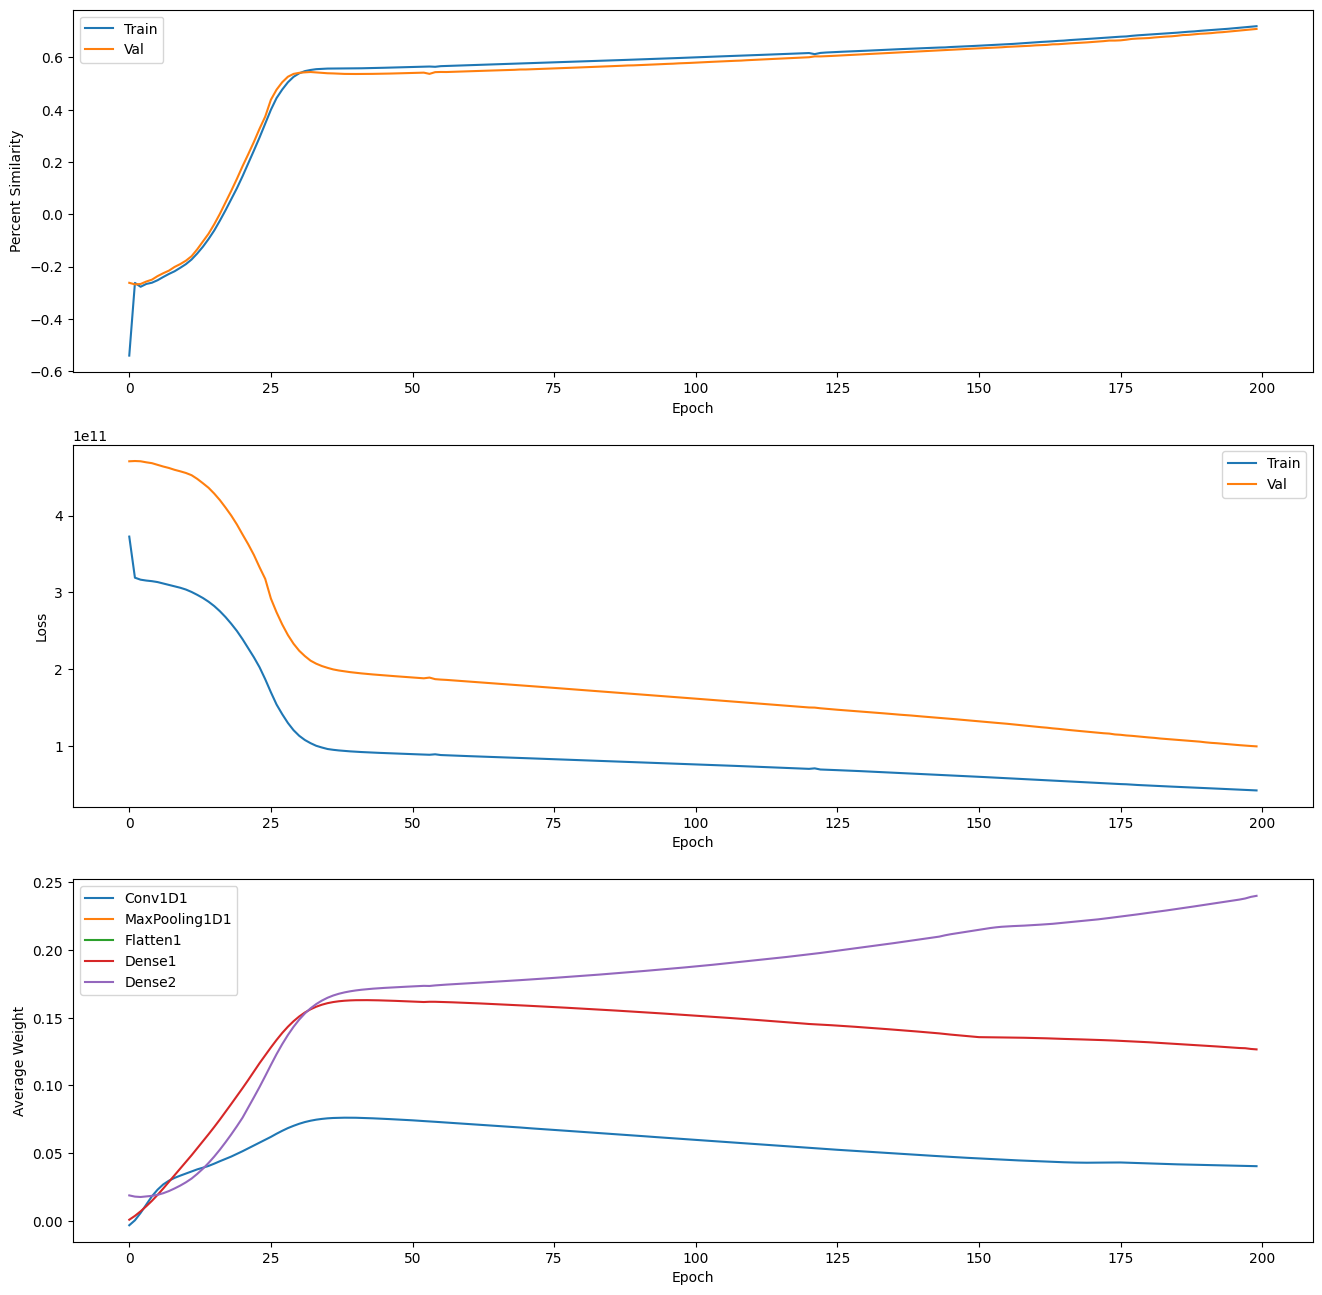

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3,1,1)
plt.plot('epoch','train_percent',data=cnn_df,label="Train")
plt.plot('epoch','val_percent',data=cnn_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Percent Similarity")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,2)
plt.plot('epoch','loss',data=cnn_df,label="Train")
plt.plot('epoch','val_loss',data=cnn_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,3)
for col in model_layers.columns:
  plt.plot(model_layers.index,col,data=model_layers,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
#plt.axis([0,500,0,1])
plt.legend()

plt.show()

Perform grid search on various hyperparameters for the Adam optimizer.

In [ ]:
def build_cnn_new(learning_rate=0.05,beta_1=0.9,beta_2=0.999):
    input_shape = (12,1)
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    model.add(Dense(50, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    # Uses MSE as loss function, typical for regression task
    return model

In [ ]:
learning_rate = [0.0005,0.001,0.005,0.01,0.05]
beta_1 = [0.9,0.99,0.999]
beta_2 = [0.9,0.99,0.999]
param_grid = dict(model__optimizer__learning_rate=learning_rate, model__optimizer__beta_1=beta_1, model__optimizer__beta_2=beta_2)
estimator = KerasRegressor(model=build_cnn_new, epochs=50, batch_size=32, validation_split=0.2, callbacks=[customCallback()])
grid1 = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', return_train_score=True)

In [ ]:
grid1_history = grid1.fit(X_train,y_train,verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
grid1_history.best_score_

-81954160640.0

In [ ]:
grid1_history.best_params_

{'model__optimizer__beta_1': 0.9,
 'model__optimizer__beta_2': 0.99,
 'model__optimizer__learning_rate': 0.0005}

Create new CNN with updated hyperparameters slightly tweaked from best results of the grid search results. (We will be slightly tweaking the Adam optimizer parameters throughout the model refining process to get the best results for each model we try)

In [ ]:
def build_cnn_adam_upt(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    model.add(Dense(50, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    #model_weights = weights(model.layers[0])
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.99, beta_2=0.99)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    # Uses MSE as loss function, typical for regression task
    return model

# Example input shape, will be in form of our data
cnn_input_shape = (12, 1)  # 13 features, 1 row per input
cnn_model_adam_upt = build_cnn_adam_upt(cnn_input_shape)
cnn_model_adam_upt.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_617"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_617 (Conv1D)                  │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_617 (MaxPooling1D)     │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_617 (Flatten)                │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1764 (Dense)                   │ (None, 50)                  │          16,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1765 (Dense)                   │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,357 (63.89 KB)

 Trainable params: 16,357 (63.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history_adam_upt = cnn_model_adam_upt.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val,y_val), callbacks=[customCallback()], verbose=0)

In [ ]:
cnn_df_adam_upt = pd.DataFrame(columns=['epoch','train_percent','val_percent','loss','val_loss'])
cnn_df_adam_upt['epoch'] = cnn_history_adam_upt.epoch
cnn_df_adam_upt['train_percent'] = cnn_history_adam_upt.history['percent_sim']
cnn_df_adam_upt['val_percent'] = cnn_history_adam_upt.history['val_percent_sim']
cnn_df_adam_upt['loss'] = cnn_history_adam_upt.history['loss']
cnn_df_adam_upt['val_loss'] = cnn_history_adam_upt.history['val_loss']

name = []
for layer in cnn_model_adam_upt.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers_adam_upt = pd.DataFrame(columns=name)
for i,w in enumerate(cnn_model_adam_upt.all_weights):
  model_layers_adam_upt.loc[i] = w

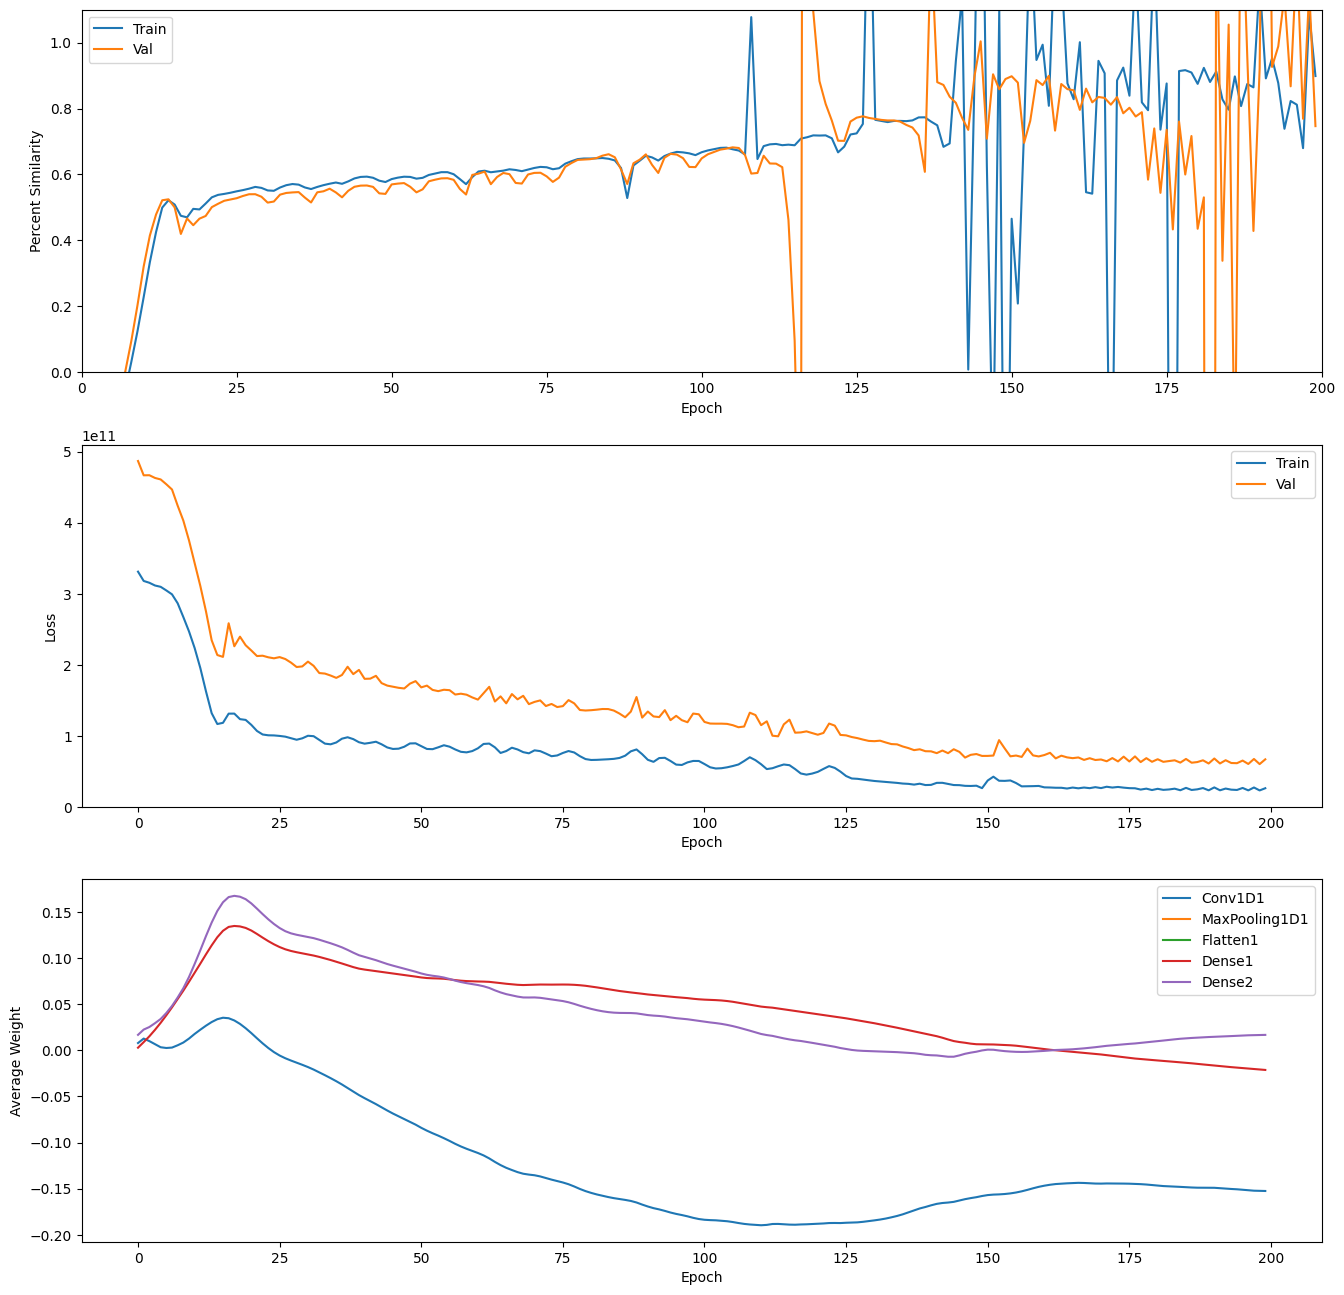

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3,1,1)
plt.plot('epoch','train_percent',data=cnn_df_adam_upt,label="Train")
plt.plot('epoch','val_percent',data=cnn_df_adam_upt,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Percent Similarity")
plt.axis([0,200,0,1.1])
plt.legend()

plt.subplot(3,1,2)
plt.plot('epoch','loss',data=cnn_df_adam_upt,label="Train")
plt.plot('epoch','val_loss',data=cnn_df_adam_upt,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.axis([0,200,0,1.1])
plt.legend()

plt.subplot(3,1,3)
for col in model_layers_adam_upt.columns:
  plt.plot(model_layers_adam_upt.index,col,data=model_layers_adam_upt,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
#plt.axis([0,500,0,1.1])
plt.legend()

plt.show()

Above epoch vs percent similarity graph shows that the model converges more quickly and likely would need fewer epochs.

In [ ]:
#Function to add given # of layers with given # of neurons
@keras.utils.register_keras_serializable(package="my_package", name="add_layer")
def add_layer(model,num_layer,neurons):
  for i in range(num_layer):
    model.add(Dense(neurons,activation='relu'))

Perform grid search on various numbers of layers to add and various numbers of neurons per layer

In [ ]:
def build_cnn_add_layers(num_layer=2, neurons=50):
    input_shape = (12,1)
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    add_layer(model,num_layer,neurons)
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    # Uses MSE as loss function, typical for regression task
    return model

In [ ]:
num_layers = [1,2,5,10,20]
neurons = [100,50,20]
param_grid2 = dict(model__add_layer__num_layer=num_layers, model__add_layer__neurons=neurons)
estimator2 = KerasRegressor(model=build_cnn_add_layers, epochs=100, batch_size=32, validation_split=0.2, callbacks=[customCallback()])
grid2 = GridSearchCV(estimator=estimator2, param_grid=param_grid2, cv=2, scoring='neg_mean_squared_error', return_train_score=True)

In [ ]:
grid2_history = grid2.fit(X_train,y_train,verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
grid2_history.cv_results_

{'mean_fit_time': array([ 9.47254658,  9.66100323,  9.87481582,  9.22284949, 10.82068479,
         9.52744353, 10.11985731, 15.86352515, 11.45340192, 11.419312  ,
        11.67151952, 11.47299731, 11.84087145, 11.45740378, 11.1032145 ]),
 'std_fit_time': array([0.61074352, 0.25751626, 0.18497503, 0.54569876, 0.66332734,
        0.64183104, 0.15155888, 5.75256276, 0.34745491, 0.32522988,
        0.37289596, 0.12303078, 0.71304405, 0.26701224, 0.08177114]),
 'mean_score_time': array([0.29778898, 0.19618714, 0.28990316, 0.20375359, 0.19677293,
        0.19448853, 0.2010262 , 0.26595068, 0.28873408, 0.20825613,
        0.20472288, 0.20728636, 0.28749442, 0.20427239, 0.30234909]),
 'std_score_time': array([9.35353041e-02, 3.51703167e-03, 9.91890430e-02, 8.87429714e-03,
        4.21082973e-03, 4.12011147e-03, 1.46341324e-03, 5.57045937e-02,
        8.05901289e-02, 1.01315975e-03, 1.83629990e-03, 2.55107880e-05,
        7.97262192e-02, 1.43063068e-03, 9.89632607e-02]),
 'param_model__add_laye

In [ ]:
grid2_history.best_score_

-71323926528.0

In [ ]:
grid2_history.best_params_

{'model__add_layer__neurons': 100, 'model__add_layer__num_layer': 20}

Update model to add an optimal 20 layers with 100 neurons each.

In [ ]:
def build_cnn_add_layers_upt(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    add_layer(model,20,100)
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    #model_weights = weights(model.layers[0])
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    #model.compile(optimizer='adam', loss='mse', metrics=['mse',percent_sim,model_weights]) # Compiles the model, uses Adam optimizer which combines the advantages of Adaptive Gradient Algorithm and Root Mean Square Propagation
    # Uses MSE as loss function, typical for regression task
    return model

# Example input shape, will be in form of our data
cnn_input_shape = (12, 1)  # 13 features, 1 row per input
cnn_model_add_layers_upt = build_cnn_add_layers_upt(cnn_input_shape)
cnn_model_add_layers_upt.summary()

Model: "sequential_744"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_744 (Conv1D)                  │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_744 (MaxPooling1D)     │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_744 (Flatten)                │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2160 (Dense)                   │ (None, 100)                 │          32,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2161 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2162 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2163 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2164 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2165 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2166 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2167 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2168 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2169 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2170 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2171 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2172 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2173 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2174 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2175 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2176 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2177 (Dense)                   │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 224,357 (876.39 KB)

 Trainable params: 224,357 (876.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history_add_layers_upt = cnn_model_add_layers_upt.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val,y_val), callbacks=[customCallback()], verbose=0)

In [ ]:
cnn_df_add_layers_upt = pd.DataFrame(columns=['epoch','train_percent','val_percent','loss','val_loss'])
cnn_df_add_layers_upt['epoch'] = cnn_history_add_layers_upt.epoch
cnn_df_add_layers_upt['train_percent'] = cnn_history_add_layers_upt.history['percent_sim']
cnn_df_add_layers_upt['val_percent'] = cnn_history_add_layers_upt.history['val_percent_sim']
cnn_df_add_layers_upt['loss'] = cnn_history_add_layers_upt.history['loss']
cnn_df_add_layers_upt['val_loss'] = cnn_history_add_layers_upt.history['val_loss']

name = []
for layer in cnn_model_add_layers_upt.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers_add_layers_upt = pd.DataFrame(columns=name)
for i,w in enumerate(cnn_model_add_layers_upt.all_weights):
  model_layers_add_layers_upt.loc[i] = w

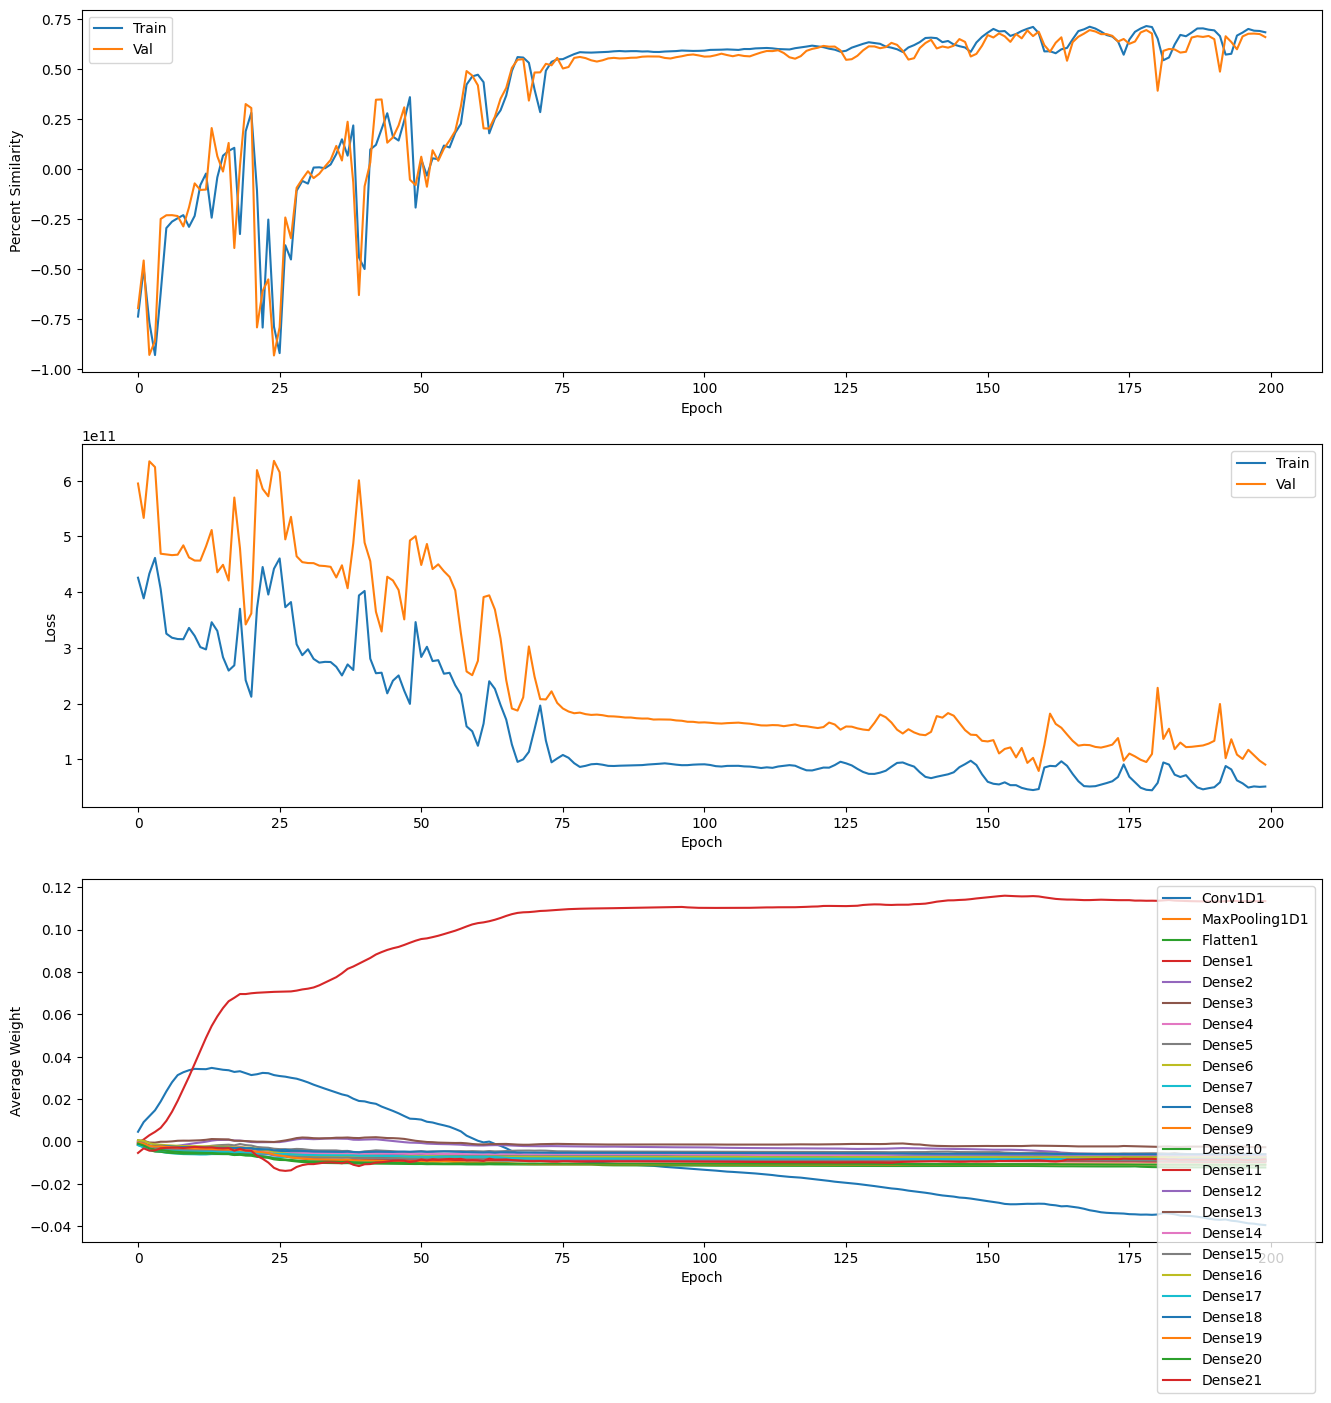

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3,1,1)
plt.plot('epoch','train_percent',data=cnn_df_add_layers_upt,label="Train")
plt.plot('epoch','val_percent',data=cnn_df_add_layers_upt,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Percent Similarity")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,2)
plt.plot('epoch','loss',data=cnn_df_add_layers_upt,label="Train")
plt.plot('epoch','val_loss',data=cnn_df_add_layers_upt,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,3)
for col in model_layers_add_layers_upt.columns:
  plt.plot(model_layers_add_layers_upt.index,col,data=model_layers_add_layers_upt,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
#plt.axis([0,500,0,1])
plt.legend()

plt.show()

Percent similarity has a great deal of variance in the earlier epochs and flattens out at a rate of less than 0.75.  We will now decrease the number of layers added to 10, and decrease the neurons per layer to 50, and see if this helps improve the graphs.

In [ ]:
def build_cnn_add_layers_10(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    add_layer(model,10,50)
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.99, beta_2=0.99)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    # Uses MSE as loss function, typical for regression task
    return model

# Example input shape, will be in form of our data
cnn_input_shape = (12, 1)  # 13 features, 1 row per input
cnn_model_add_layers_10 = build_cnn_add_layers_10(cnn_input_shape)
cnn_model_add_layers_10.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_712"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_712 (Conv1D)                  │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_712 (MaxPooling1D)     │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_712 (Flatten)                │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2056 (Dense)                   │ (None, 50)                  │          16,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2057 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2058 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2059 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2060 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2061 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2062 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2063 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2064 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2065 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2066 (Dense)                   │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,307 (153.54 KB)

 Trainable params: 39,307 (153.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history_add_layers_10 = cnn_model_add_layers_10.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val,y_val), callbacks=[customCallback()], verbose=0)

In [ ]:
cnn_df_add_layers_10 = pd.DataFrame(columns=['epoch','train_percent','val_percent','loss','val_loss'])
cnn_df_add_layers_10['epoch'] = cnn_history_add_layers_10.epoch
cnn_df_add_layers_10['train_percent'] = cnn_history_add_layers_10.history['percent_sim']
cnn_df_add_layers_10['val_percent'] = cnn_history_add_layers_10.history['val_percent_sim']
cnn_df_add_layers_10['loss'] = cnn_history_add_layers_10.history['loss']
cnn_df_add_layers_10['val_loss'] = cnn_history_add_layers_10.history['val_loss']

name = []
for layer in cnn_model_add_layers_10.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers_add_layers_10 = pd.DataFrame(columns=name)
for i,w in enumerate(cnn_model_add_layers_10.all_weights):
  model_layers_add_layers_10.loc[i] = w

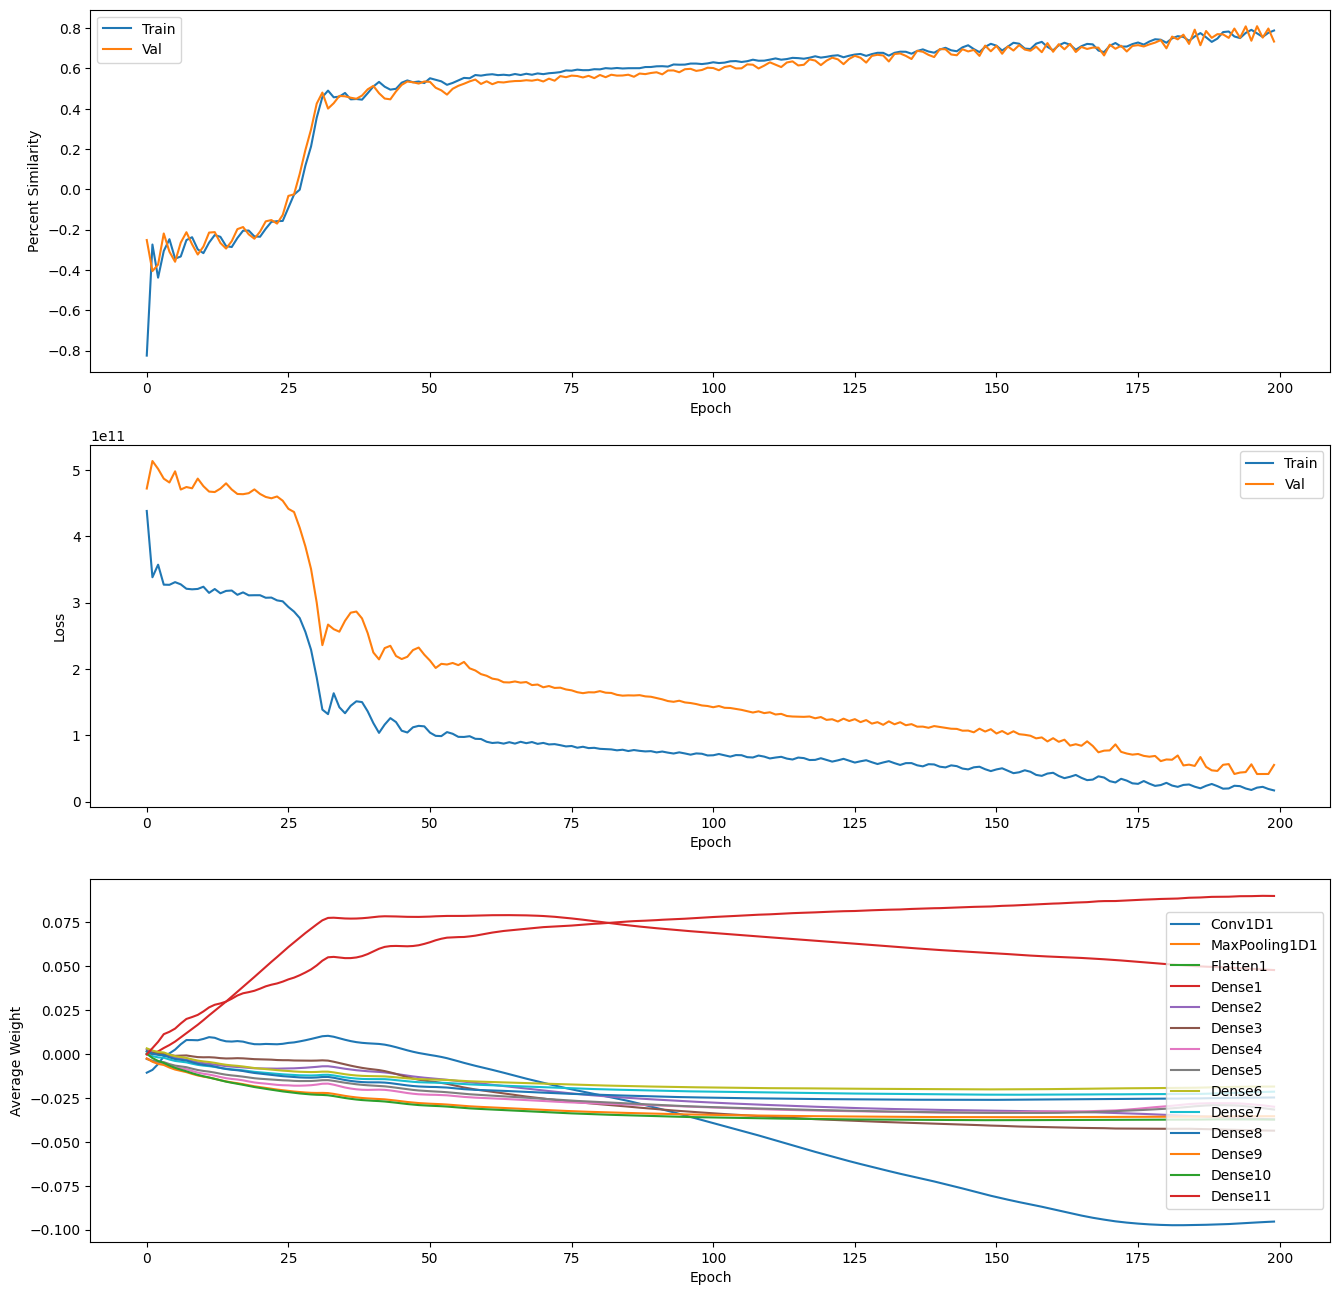

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3,1,1)
plt.plot('epoch','train_percent',data=cnn_df_add_layers_10,label="Train")
plt.plot('epoch','val_percent',data=cnn_df_add_layers_10,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Percent Similarity")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,2)
plt.plot('epoch','loss',data=cnn_df_add_layers_10,label="Train")
plt.plot('epoch','val_loss',data=cnn_df_add_layers_10,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,3)
for col in model_layers_add_layers_10.columns:
  plt.plot(model_layers_add_layers_10.index,col,data=model_layers_add_layers_10,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
#plt.axis([0,500,0,1])
plt.legend()

plt.show()

Tweaking the parameters slightly has inproved the graphs a lot, and the percent similarity is now around 0.8.

In [ ]:
#Function to add layers with Leaky ReLU activation with given slope
@keras.utils.register_keras_serializable(package="my_package", name="add_layer_lr")
def add_layer_lr(model,num_layer,neurons,slope):
  act = tf.keras.layers.LeakyReLU(negative_slope=slope)
  for i in range(num_layer):
    model.add(Dense(neurons,activation=act))

Create CNN with Leaky ReLU, and perform a grid search on multiple slopes

In [ ]:
def build_cnn_leaky_relu(slope=0.1):
    input_shape = (12,1)
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    add_layer_lr(model,10,50,slope)
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    # Uses MSE as loss function, typical for regression task
    return model

In [ ]:
slope = [0.1,0.3,0.5,0.8]
param_grid3 = dict(model__add_layer__slope=slope)
estimator3 = KerasRegressor(model=build_cnn_leaky_relu, epochs=100, batch_size=32, validation_split=0.2, callbacks=[customCallback()])
grid3 = GridSearchCV(estimator=estimator3, param_grid=param_grid3, cv=3, scoring='neg_mean_squared_error', return_train_score=True)

In [ ]:
grid3_history = grid3.fit(X_train,y_train,verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
grid3_history.cv_results_

{'mean_fit_time': array([15.35448122, 15.36425241, 15.69075886, 15.51357214]),
 'std_fit_time': array([0.23921189, 0.25807223, 0.51680006, 0.190671  ]),
 'mean_score_time': array([0.45985778, 0.35108415, 0.39575521, 0.4496909 ]),
 'std_score_time': array([0.1792878 , 0.02104211, 0.07326971, 0.18825555]),
 'param_model__add_layer__slope': masked_array(data=[0.1, 0.3, 0.5, 0.8],
              mask=[False, False, False, False],
        fill_value=1e+20),
 'params': [{'model__add_layer__slope': 0.1},
  {'model__add_layer__slope': 0.3},
  {'model__add_layer__slope': 0.5},
  {'model__add_layer__slope': 0.8}],
 'split0_test_score': array([-1.14865299e+11, -5.79482337e+10, -7.02052434e+10, -6.28003963e+10]),
 'split1_test_score': array([-5.78418401e+10, -1.36852783e+11, -1.10368735e+11, -1.05593348e+11]),
 'split2_test_score': array([-5.53647432e+10, -1.13506083e+11, -1.01181645e+11, -4.71138263e+10]),
 'mean_test_score': array([-7.60239609e+10, -1.02769033e+11, -9.39185411e+10, -7.18358569e+1

In [ ]:
grid3_history.best_score_

-71835856896.0

In [ ]:
grid3_history.best_params_

{'model__add_layer__slope': 0.8}

Update model with the best performing parameter (0.8) for the slope

In [ ]:
def build_cnn_leaky_relu(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    add_layer_lr(model,10,50,0.8)
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    # Uses MSE as loss function, typical for regression task
    return model

# Example input shape, will be in form of our data
cnn_input_shape = (12, 1)  # 13 features, 1 row per input
cnn_model_leaky_relu = build_cnn_leaky_relu(cnn_input_shape)
cnn_model_leaky_relu.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_775"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_775 (Conv1D)                  │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_775 (MaxPooling1D)     │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_775 (Flatten)                │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2511 (Dense)                   │ (None, 50)                  │          16,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2512 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2513 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2514 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2515 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2516 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2517 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2518 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2519 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2520 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2521 (Dense)                   │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,307 (153.54 KB)

 Trainable params: 39,307 (153.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history_leaky_relu = cnn_model_leaky_relu.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_val,y_val), callbacks=[customCallback()], verbose=0)

In [ ]:
cnn_df_leaky_relu = pd.DataFrame(columns=['epoch','train_percent','val_percent','loss','val_loss'])
cnn_df_leaky_relu['epoch'] = cnn_history_leaky_relu.epoch
cnn_df_leaky_relu['train_percent'] = cnn_history_leaky_relu.history['percent_sim']
cnn_df_leaky_relu['val_percent'] = cnn_history_leaky_relu.history['val_percent_sim']
cnn_df_leaky_relu['loss'] = cnn_history_leaky_relu.history['loss']
cnn_df_leaky_relu['val_loss'] = cnn_history_leaky_relu.history['val_loss']

name = []
for layer in cnn_model_leaky_relu.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers_leaky_relu = pd.DataFrame(columns=name)
for i,w in enumerate(cnn_model_leaky_relu.all_weights):
  model_layers_leaky_relu.loc[i] = w

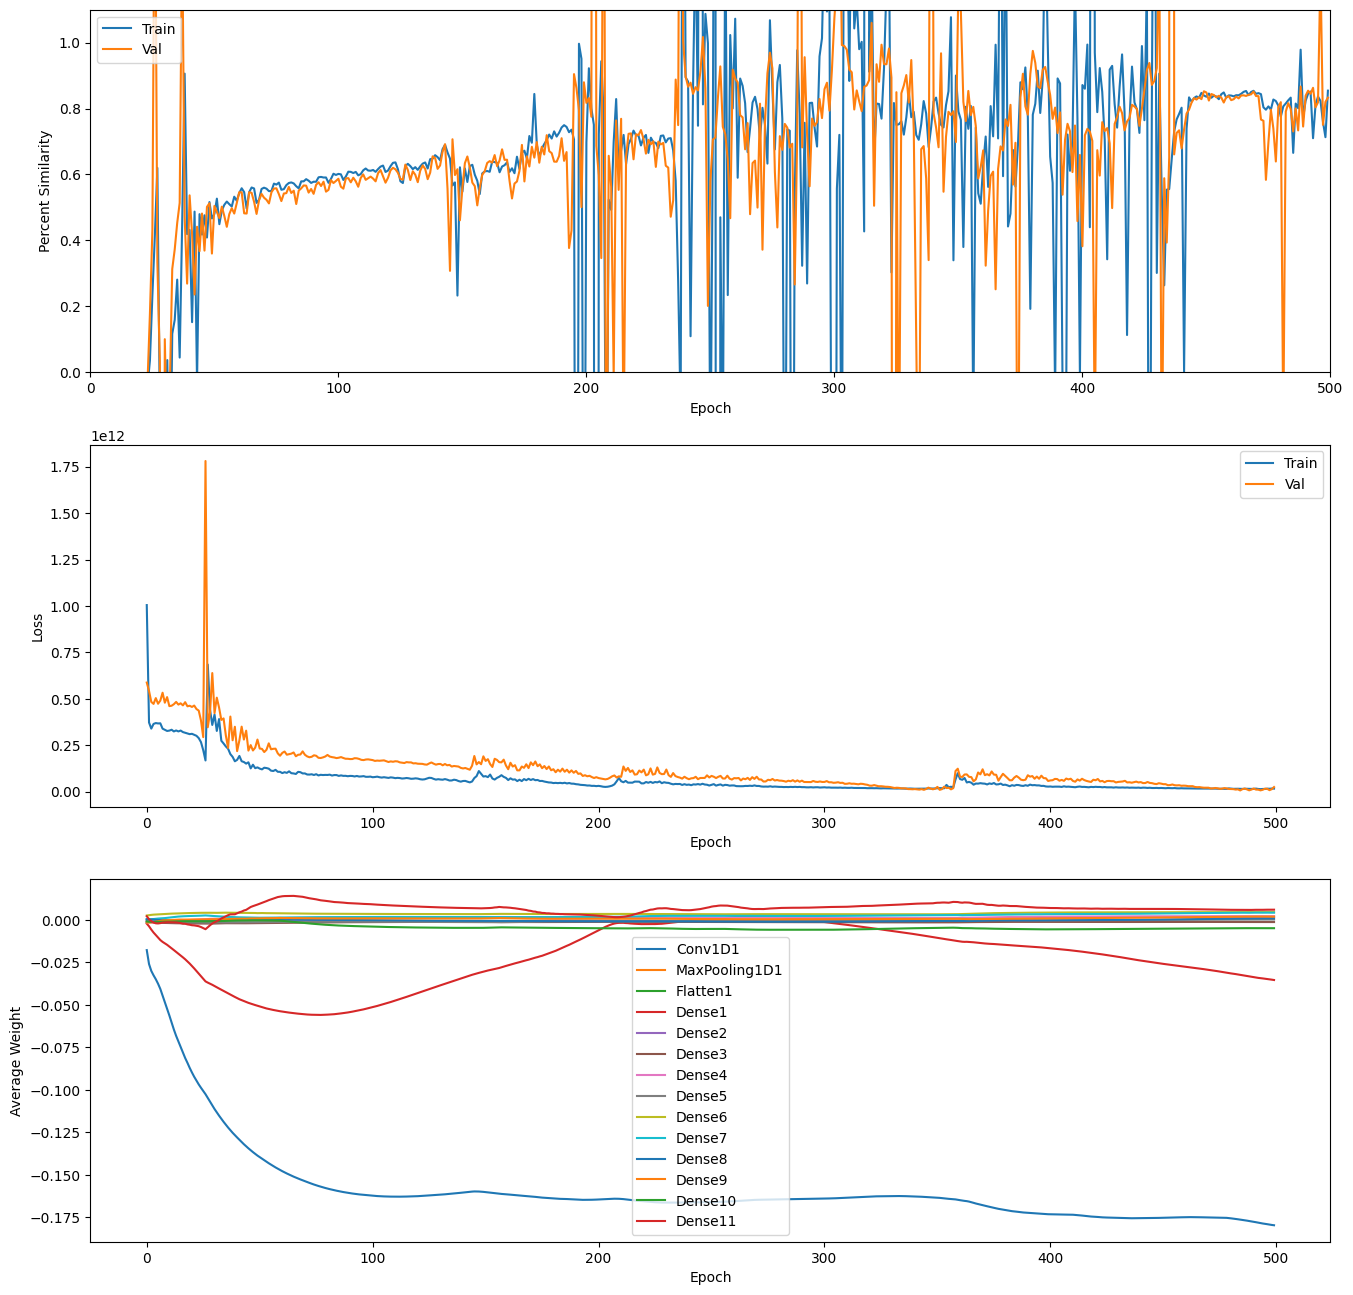

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3,1,1)
plt.plot('epoch','train_percent',data=cnn_df_leaky_relu,label="Train")
plt.plot('epoch','val_percent',data=cnn_df_leaky_relu,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Percent Similarity")
plt.axis([0,500,0,1.1])
plt.legend()

plt.subplot(3,1,2)
plt.plot('epoch','loss',data=cnn_df_leaky_relu,label="Train")
plt.plot('epoch','val_loss',data=cnn_df_leaky_relu,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,3)
for col in model_layers_leaky_relu.columns:
  plt.plot(model_layers_leaky_relu.index,col,data=model_layers_leaky_relu,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
#plt.axis([0,500,0,1])
plt.legend()

plt.show()

The graphs are a bit all over the place.  While the percent similarity is heading towards upwards of 0.8, there are too many spikes and drops for this value to be reliable.  We will try decreasing the slope to see if it helps

In [ ]:
def build_cnn_leaky_relu_1(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling1D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    add_layer_lr(model,10,50,0.1)
    model.add(Dense(1, activation='linear'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.99, beta_2=0.999)
    model.compile(optimizer=opt, loss='mse', metrics=['mse',percent_sim])
    # Uses MSE as loss function, typical for regression task
    return model

# Example input shape, will be in form of our data
cnn_input_shape = (12, 1)  # 13 features, 1 row per input
cnn_model_leaky_relu_1 = build_cnn_leaky_relu_1(cnn_input_shape)
cnn_model_leaky_relu_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_776"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_776 (Conv1D)                  │ (None, 10, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_776 (MaxPooling1D)     │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_776 (Flatten)                │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2522 (Dense)                   │ (None, 50)                  │          16,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2523 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2524 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2525 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2526 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2527 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2528 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2529 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2530 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2531 (Dense)                   │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2532 (Dense)                   │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,307 (153.54 KB)

 Trainable params: 39,307 (153.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history_leaky_relu_1 = cnn_model_leaky_relu_1.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_val,y_val), callbacks=[customCallback()], verbose=0)

In [ ]:
cnn_df_leaky_relu_1 = pd.DataFrame(columns=['epoch','train_percent','val_percent','loss','val_loss'])
cnn_df_leaky_relu_1['epoch'] = cnn_history_leaky_relu_1.epoch
cnn_df_leaky_relu_1['train_percent'] = cnn_history_leaky_relu_1.history['percent_sim']
cnn_df_leaky_relu_1['val_percent'] = cnn_history_leaky_relu_1.history['val_percent_sim']
cnn_df_leaky_relu_1['loss'] = cnn_history_leaky_relu_1.history['loss']
cnn_df_leaky_relu_1['val_loss'] = cnn_history_leaky_relu_1.history['val_loss']

name = []
for layer in cnn_model_leaky_relu_1.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers_leaky_relu_1 = pd.DataFrame(columns=name)
for i,w in enumerate(cnn_model_leaky_relu_1.all_weights):
  model_layers_leaky_relu_1.loc[i] = w

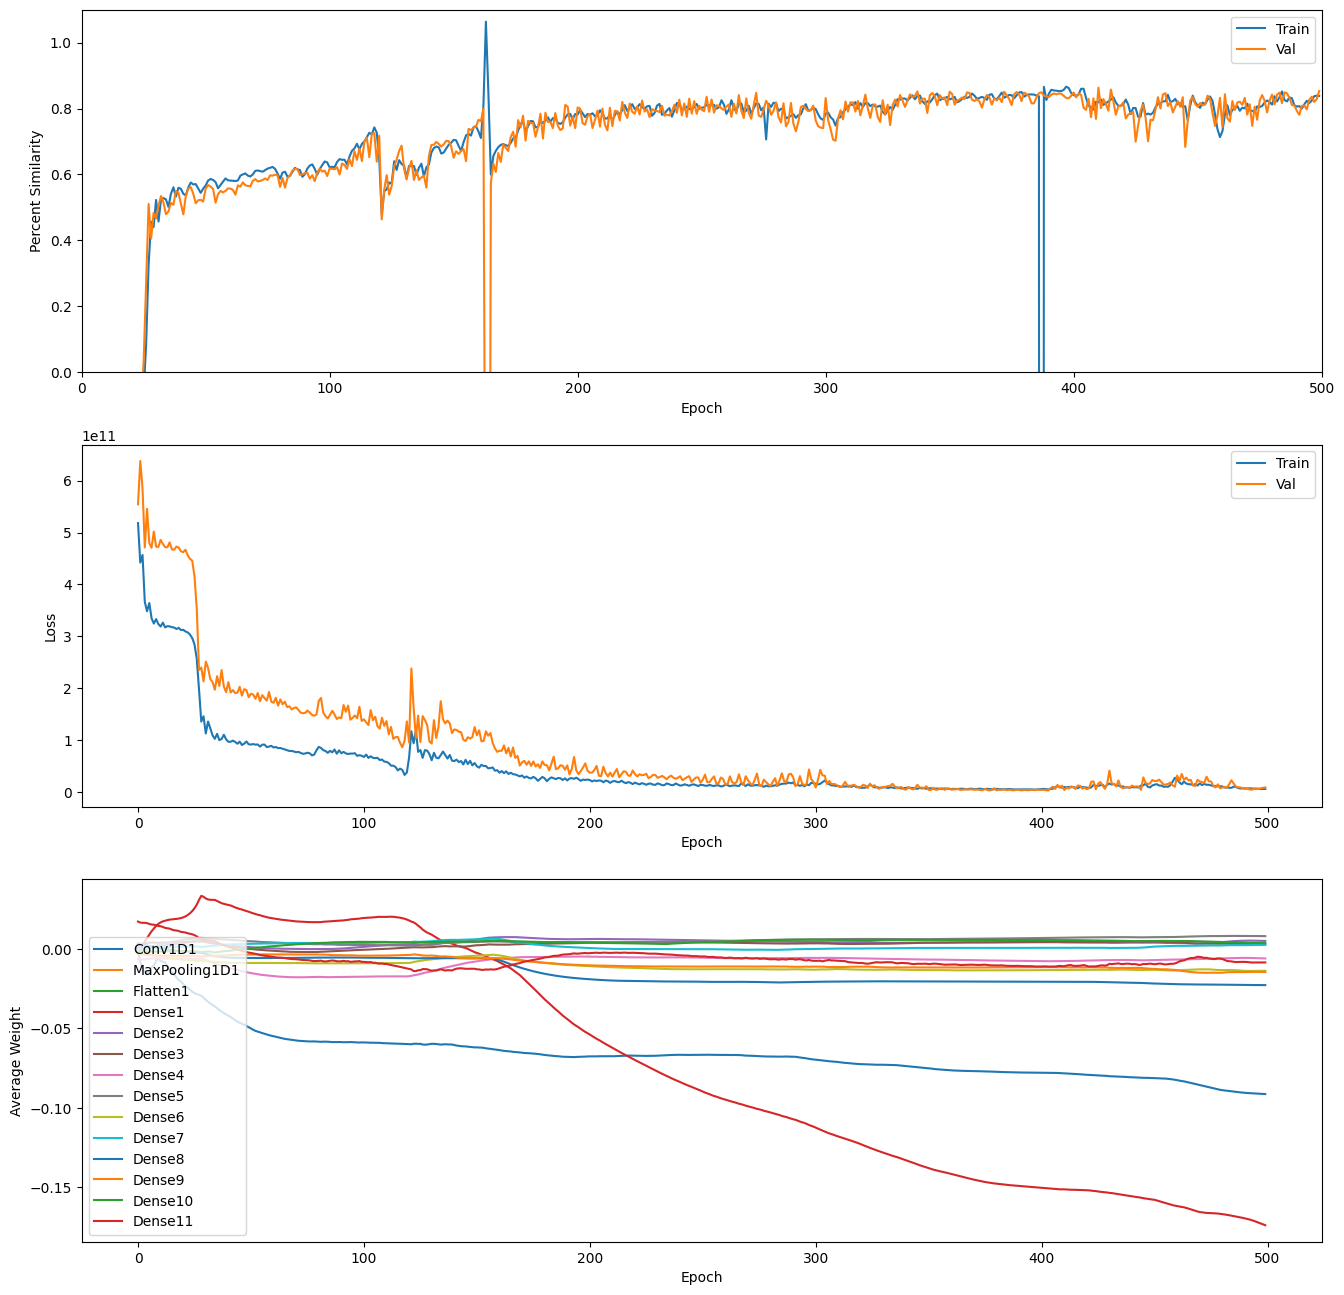

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3,1,1)
plt.plot('epoch','train_percent',data=cnn_df_leaky_relu_1,label="Train")
plt.plot('epoch','val_percent',data=cnn_df_leaky_relu_1,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Percent Similarity")
plt.axis([0,500,0,1.1])
plt.legend()

plt.subplot(3,1,2)
plt.plot('epoch','loss',data=cnn_df_leaky_relu_1,label="Train")
plt.plot('epoch','val_loss',data=cnn_df_leaky_relu_1,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.axis([0,500,0,1])
plt.legend()

plt.subplot(3,1,3)
for col in model_layers_leaky_relu_1.columns:
  plt.plot(model_layers_leaky_relu_1.index,col,data=model_layers_leaky_relu_1,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
#plt.axis([0,500,0,1])
plt.legend()

plt.show()

In [ ]:
cnn_df_leaky_relu_1.tail(10)

,epoch,train_percent,val_percent,loss,val_loss
490,490,0.806139,0.792813,7.396603e+09,7.027200e+09
491,491,0.807183,0.781059,7.260057e+09,7.314431e+09
492,492,0.800003,0.808222,7.509295e+09,5.472114e+09
493,493,0.812454,0.809328,7.134245e+09,5.021304e+09
494,494,0.823616,0.797300,6.949563e+09,6.556147e+09
495,495,0.816765,0.826861,7.012859e+09,6.414518e+09
496,496,0.823889,0.835870,6.470445e+09,6.522345e+09
497,497,0.837516,0.820170,6.123490e+09,7.507982e+09
498,498,0.839178,0.828555,6.325103e+09,8.558858e+09
499,499,0.838236,0.852978,6.472157e+09,9.175374e+09


Here, the percent similarity is much more consistent and has surpassed 0.8.  This latest model seems to yield the best results of any that we tried

Import temporal data

In [ ]:
temporal_data = pd.read_csv('/content/cities.csv')
display(temporal_data)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,238929.371135,240200.909361,...,7.522116e+05,7.513148e+05,7.494048e+05,7.468745e+05,7.437790e+05,7.409241e+05,7.396390e+05,7.401279e+05,7.421979e+05,7.464513e+05
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,228164.787100,228510.253426,...,9.211679e+05,9.327055e+05,9.485068e+05,9.646931e+05,9.780197e+05,9.869309e+05,9.918120e+05,9.886334e+05,9.809308e+05,9.741047e+05
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,102112.819227,102086.875044,...,2.655243e+05,2.664778e+05,2.674468e+05,2.679088e+05,2.680646e+05,2.679083e+05,2.677027e+05,2.679266e+05,2.684450e+05,2.694611e+05
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,141884.310885,141922.218100,...,2.818053e+05,2.830770e+05,2.848743e+05,2.866009e+05,2.876437e+05,2.881403e+05,2.880526e+05,2.879695e+05,2.884701e+05,2.899088e+05
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,98118.182518,98209.273971,...,2.629352e+05,2.631602e+05,2.632970e+05,2.628491e+05,2.620033e+05,2.607361e+05,2.592236e+05,2.581205e+05,2.575474e+05,2.577109e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6050,6784,6305,Riverdale,city,UT,UT,"Ogden-Clearfield, UT",Weber County,151150.385072,150956.455643,...,4.357689e+05,4.378242e+05,4.401952e+05,4.422043e+05,4.453491e+05,4.475556e+05,4.490030e+05,4.481181e+05,4.480627e+05,4.492343e+05
6051,49038,6305,Edgemere,city,MD,MD,"Baltimore-Columbia-Towson, MD",Baltimore County,142746.332786,142842.625660,...,3.484391e+05,3.497206e+05,3.503059e+05,3.504033e+05,3.502321e+05,3.493983e+05,3.484879e+05,3.479906e+05,3.486213e+05,3.507029e+05
6052,27236,6305,Stacy,city,MN,MN,"Minneapolis-St. Paul-Bloomington, MN-WI",Chisago County,122254.861532,122610.257918,...,3.869405e+05,3.890139e+05,3.900982e+05,3.906250e+05,3.904037e+05,3.905825e+05,3.912345e+05,3.921929e+05,3.934521e+05,3.952778e+05
6053,34030,6309,Solvang,city,CA,CA,"Santa Maria-Santa Barbara, CA",Santa Barbara County,390224.966124,391477.087950,...,1.247950e+06,1.270690e+06,1.293702e+06,1.311170e+06,1.322837e+06,1.327342e+06,1.329777e+06,1.330020e+06,1.331496e+06,1.340079e+06


In [ ]:
az_cities = pd.DataFrame(temporal_data)
az_cities = az_cities[az_cities['StateName'] == 'AZ']

# Neighborhhoods of interest
neighborhoods = ['Alpine','ApacheJunction','AshFork','Avondale','Benson','Bisbee','Bouse','Buckeye','BullheadCity','Campverde','Carefree','CasaGrande','CaveCreek','Central','Chandler','Clarkdale','Clifton','Cochise','Concho','Coolidge','Cornville',
                 'Douglas','Duncan','Eagar','ElMirage','Elfrida','Flagstaff','ForestLakes','FortMohave','FountainHills','Fredonia','Gilbert','Glendale','Globe','GoldenValley','Goodyear','GreenValley','Greer','HappyJack','Heber','Hereford','Holbrook',
                 'HuachucaCity','Kingman','LakeHavasuCity','Lakeside','Laveen','LitchfieldPark','Marana','Maricopa','Mcneal','Mesa','Miami','MohaveValley','MormonLake','MundsPark','Nampa','Newport','Nogales','OroValley','PAGE','ParadiseValley','Parker',
                 'Parks','Patagonia','Paulden','Payson','Peoria','Phoenix','Pima','Pine','PineKnollShores','Pinetop','Prescott','PrescottValley','Quartzite','Quartzsite','QueenCreek','RioRico','RioVerde','Roosevelt','Safford','Sahuarita','SaintDavid',
                 'SaintJohns','Salome','SanTanValley','Sanders','Scottsdale','Sedona','SierraVista','Snowflake','Springerville','StarValley','Strawberry','SunCity','SunCityWest','SunValley','Surprise','Tempe','Thatcher',
                 'Tolleson','Tombstone','Tonopah','Topock','Tucson','Vail','Vernon','Wickenburg','Willcox','Williams','Winona','Winslow','Young','Yucca','Yuma']

# New test dataframe
test_group = az_cities.loc[az_cities['RegionName'].isin(neighborhoods)]
test_group = test_group.drop(columns=['RegionID', 'SizeRank', 'CountyName','RegionType', 'StateName', 'State', 'Metro'])

In [ ]:
def melt_data(df):
    """
    Takes arizona zillow data and returns long-form datetime dataframe with the datetime column names as the index and the values as the 'values' column.
    If more than one row is passed in the wide-form dataset the values column will be the mean fo the values from the datetime columns in all the rows.
    """
    melted = pd.melt(df,
                     id_vars=['RegionName'],
                     var_name='time',
                     value_name='HVI')
    melted['time'] = pd.to_datetime(melted['time'])
    melted = melted.dropna(subset=['HVI'])
    return melted
    return melted.groupby('time').aggregate({'HVI':'mean'})

temporal_data = melt_data(test_group)
print(temporal_data['RegionName'].unique())

['Phoenix' 'Tucson' 'Mesa' 'Chandler' 'Gilbert' 'Glendale' 'Scottsdale'
 'Peoria' 'Tempe' 'Surprise' 'Flagstaff' 'Goodyear' 'Buckeye' 'Avondale'
 'Maricopa' 'Prescott' 'Kingman' 'Tolleson' 'Marana' 'Sahuarita' 'Nogales'
 'Payson' 'Sedona' 'Coolidge' 'Safford' 'Vail' 'Globe' 'Winslow'
 'Snowflake' 'Yuma' 'Benson' 'Willcox' 'Hereford' 'Douglas' 'Parker']


In [ ]:
# Step 1: Filter for common cities
common_cities = set(spatial_data['city']).intersection(set(temporal_data['RegionName']))

# Filter both datasets to only include common cities
spatial_data.drop(columns=['cityEncoded'], inplace=True) #Remove label encoded city (will not be using that for final model)
filtered_spatial_data = spatial_data[spatial_data['city'].isin(common_cities)]
filtered_temporal_data = temporal_data[temporal_data['RegionName'].isin(common_cities)]

# Step 2: Exclude cities with incomplete temporal data
# Define a threshold for minimum number of data points, e.g., 290 (close to full coverage)
region_time_coverage = filtered_temporal_data.groupby('RegionName').count()['time']
complete_cities = region_time_coverage[region_time_coverage >= 290].index

# Filter datasets to include only cities with complete data
filtered_spatial_data = filtered_spatial_data[filtered_spatial_data['city'].isin(complete_cities)]
filtered_temporal_data = filtered_temporal_data[filtered_temporal_data['RegionName'].isin(complete_cities)]

# Step 3: Merge the datasets
final_combined_data = pd.merge(filtered_spatial_data, filtered_temporal_data, left_on='city', right_on='RegionName', how='inner')

# Final check for nulls
print(final_combined_data.isnull().sum())

# THIS IS FULL DATA FROM 2000 ONWARDS

price_num             0
city                  0
year                  0
house_age             0
garage_ind            0
price_per_sqft_num    0
pop2024               0
density               0
floor_space_num       0
min_school_dist       0
min_store_dist        0
beds_num              0
baths_num             0
RegionName            0
time                  0
HVI                   0
dtype: int64


In [ ]:
final_combined_data['time'] = pd.to_datetime(final_combined_data['time'])
final_combined_data = final_combined_data[(final_combined_data['time'] >= '2018-01-01') & (final_combined_data['time'] <= '2024-3-31')]

# THIS IS DATA FROM 2018 ONWARDS

Epoch 1/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - avg_diff_metric: 300702.6562 - loss: 213110325248.0000 - mean_absolute_error: 300702.7500 - val_avg_diff_metric: 163089.0469 - val_loss: 73790160896.0000 - val_mean_absolute_error: 163199.1250
Epoch 2/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 77s 28ms/step - avg_diff_metric: 147531.8594 - loss: 62219620352.0000 - mean_absolute_error: 147531.9062 - val_avg_diff_metric: 109035.3281 - val_loss: 39828553728.0000 - val_mean_absolute_error: 109093.1562
Epoch 3/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - avg_diff_metric: 113157.7188 - loss: 40447434752.0000 - mean_absolute_error: 113157.7422 - val_avg_diff_metric: 79709.3125 - val_loss: 25731526656.0000 - val_mean_absolute_error: 79735.7031
Epoch 4/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - avg_diff_metric: 91749.2891 - loss: 29616257024.0000 - mean_absolute_error: 91749.2891 - val_avg_diff_metric: 61641.7227 - val_loss: 19215628288.0000 - val_mean_absolute_error: 61656.0547
Epoch

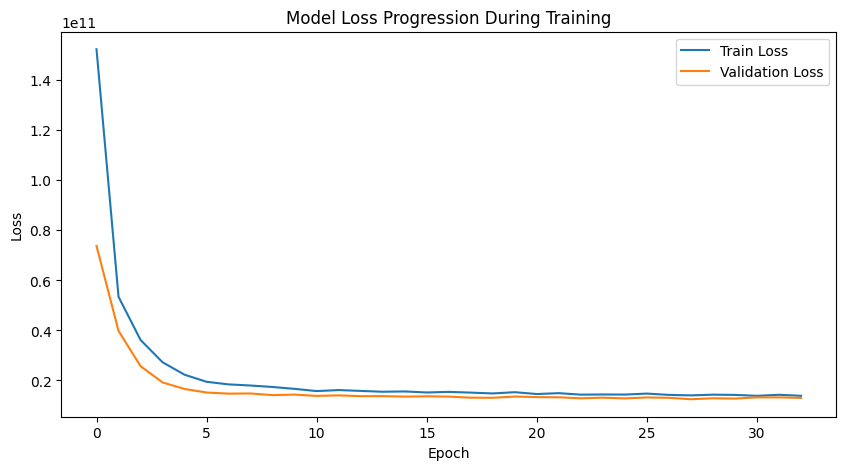

In [ ]:
# Define custom metric
def avg_diff_metric(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

# Load and prepare the dataset
final_combined_data['time'] = pd.to_datetime(final_combined_data['time'])
start_date = final_combined_data['time'].min()
final_combined_data['months_since_start'] = final_combined_data['time'].apply(lambda x: (x.year - start_date.year) * 12 + (x.month - start_date.month))

# Define and preprocess features
categorical_features = ['city']
numerical_features = ['year', 'house_age', 'garage_ind', 'price_per_sqft_num', 'pop2024', 'density', 'floor_space_num', 'min_school_dist', 'min_store_dist', 'beds_num', 'baths_num', 'months_since_start']
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features), ('cat', OneHotEncoder(), categorical_features)])
X_processed = preprocessor.fit_transform(final_combined_data[numerical_features + categorical_features])
X_processed = scipy.sparse.csr_matrix(X_processed).todense()  # Convert the sparse matrix to a dense array
#X_processed = X_processed.todense()  # Convert the sparse matrix to a dense array

# Adjust target variable to shift it by 6 months into the future
forecast_horizon = 6  # Months into the future
y_future = final_combined_data['price_num'].shift(-forecast_horizon)  # Future target prices

# Prepare HVI sequences for LSTM
sequence_length = 12  # Length of the sequence for LSTM
def prepare_sequences(x):
    return np.array([x[i:i + sequence_length] for i in range(len(x) - sequence_length + 1)])
HVI_sequences = prepare_sequences(final_combined_data['HVI'].values)

# Ensure X_processed, y_future, and HVI_sequences are all the same length
min_length = min(len(y_future.dropna()), len(HVI_sequences))
X_processed = X_processed[:min_length]
y_future = y_future.dropna()[:min_length]
HVI_sequences = HVI_sequences[:min_length]

# Split the data
X_train, X_test, y_train, y_test, HVI_train, HVI_test = train_test_split(X_processed, y_future, HVI_sequences, test_size=0.20, random_state=0)

# Reshape X_train and X_test to add the channels dimension (for CNN)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the custom metric
def avg_diff_metric(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

@keras.utils.register_keras_serializable(package="my_package", name="add_layer_lr")
def add_layer_lr(model,num_layer,neurons,slope):
  act = tf.keras.layers.LeakyReLU(negative_slope=slope)
  for i in range(num_layer):
    model = Dense(neurons,activation=act)(model)

# Define the model architecture with dropout and batch normalization
def build_model():
    cnn_input = Input(shape=(X_train.shape[1], 1))
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    add_layer_lr(x,10,50,0.1)

    lstm_input = Input(shape=(sequence_length, 1))
    y = LSTM(100, activation='relu', dropout=0.2)(lstm_input)

    # Combine CNN and LSTM outputs
    combined = concatenate([x, y])

    combined = Dense(256, activation='relu')(combined)  # Using 256 dense units

    output = Dense(1, activation='linear')(combined)
    model = Model(inputs=[cnn_input, lstm_input], outputs=output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.9)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_error', avg_diff_metric])
    return model

# Create the model
model = build_model()

# Setup early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping and custom metric
history = model.fit(
    [X_train, HVI_train], y_train, epochs=50, batch_size=32,
    validation_data=([X_test, HVI_test], y_test),
    callbacks=[early_stopping]
)

# Evaluate and plot results
loss, mean_absolute_error, avg_diff = model.evaluate([X_test, HVI_test], y_test)
print('Test MSE:', loss)
print('Average Difference:', avg_diff)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progression During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


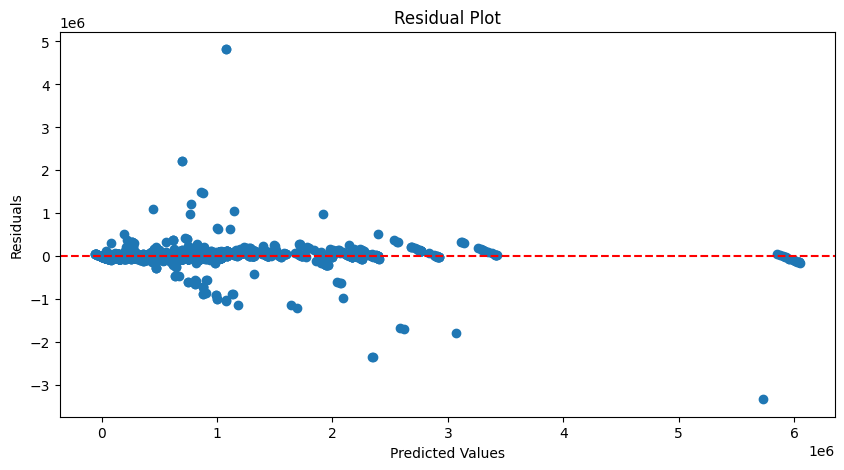

In [ ]:
predictions = model.predict([X_test, HVI_test])
residuals = y_test - predictions.flatten()

plt.figure(figsize=(10, 5))
plt.scatter(predictions.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

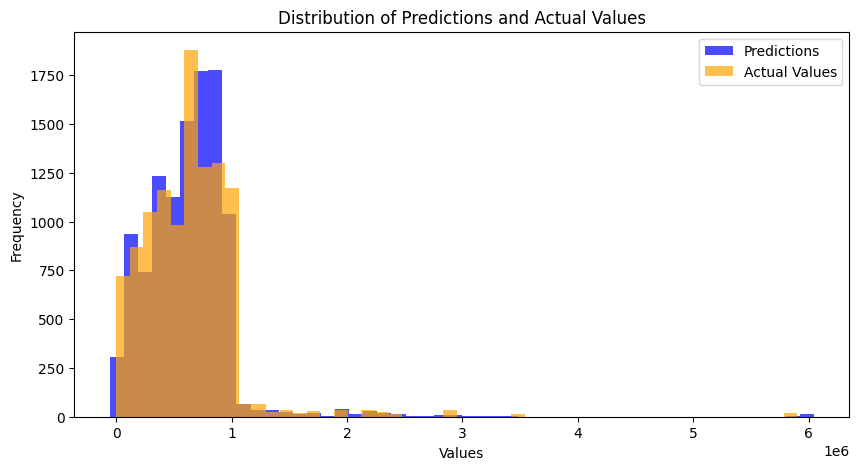

In [ ]:
plt.figure(figsize=(10, 5))
# Ensure 'predictions' and 'y_test' are correctly scaled and are the arrays containing your data
plt.hist(predictions.flatten(), bins=50, alpha=0.7, color='blue', label='Predictions')
plt.hist(y_test, bins=50, alpha=0.7, color='orange', label='Actual Values')
plt.title('Distribution of Predictions and Actual Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


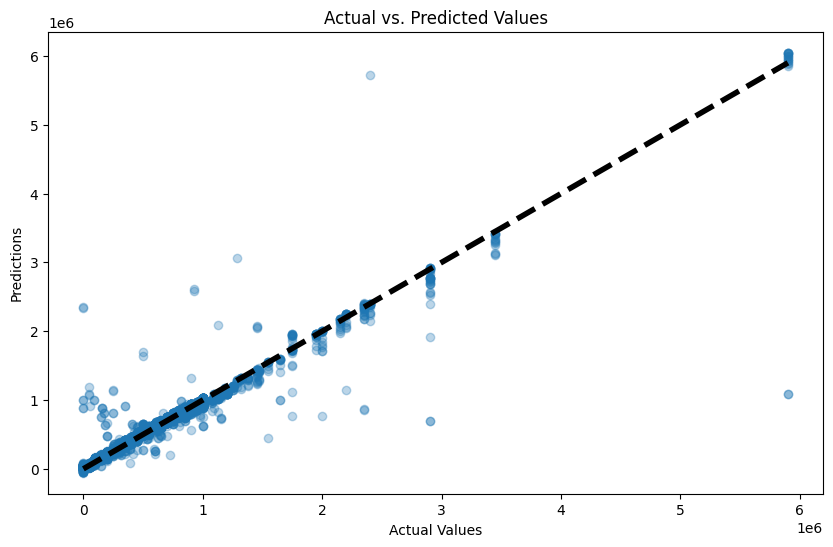

In [ ]:
import matplotlib.pyplot as plt

predictions = model.predict([X_test, HVI_test])

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted Values')
plt.show()